In [ ]:
import os
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential,load_model
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt


In [10]:
dictionary = "data_vnstock/"
df_top50 = pd.read_json("top50_tickers.json", lines=True)

# Lấy danh sách ticker
all_tickers = df_top50['ticker'].tolist()
print(all_tickers)

['DST', 'JVC', 'IMP', 'LDG', 'ITC', 'G36', 'KLB', 'IPA', 'DC4', 'VE9', 'TV2', 'DCL', 'DXG', 'EIB', 'VNE', 'AAV', 'LAS', 'KHP', 'TCB', 'REE', 'SVN', 'DRH', 'TDH', 'MBB', 'API', 'NTL', 'POW', 'NLG', 'DDV', 'BFC', 'NVL', 'CEO', 'TCH', 'TLD', 'CRE', 'SCR', 'PVS', 'MWG', 'DXS', 'BMI', 'PAC', 'HAG', 'DTI', 'VIX', 'CII', 'PET', 'VC3', 'HDG', 'HSL', 'PAN']


In [11]:
def data_train(scaled_data,training_data_len, horizon = 60):
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []
    for i in range(horizon, len(train_data)):
        x_train.append(train_data[i-horizon:i, 0])
        y_train.append(train_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train,y_train
        
def data_test(dataset,scaled_data,training_data_len, horizon = 60):
    test_data = scaled_data[training_data_len - horizon:, :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(horizon, len(test_data)):
        x_test.append(test_data[i-horizon:i, 0])
        
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    return x_test,y_test

# def data_train(scaled_data, training_data_len, horizon=30):
#     x_train, y_train = [], []
#     for i in range(horizon, training_data_len - horizon):
#         x = scaled_data[i-horizon:i, 0]                    # input: 30 ngày
#         y = scaled_data[i:i+horizon, 0]                   # output: 30 ngày tiếp theo
#         x_train.append(x)
#         y_train.append(y)
#     x_train, y_train = np.array(x_train), np.array(y_train)
#     x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
#     return x_train, y_train

# def data_test(dataset, scaled_data, training_data_len, horizon=30):
#     x_test, y_test = [], []
#     for i in range(training_data_len, len(scaled_data) - horizon):
#         x = scaled_data[i-horizon:i, 0]
#         y = dataset[i:i+horizon, 0]
#         x_test.append(x)
#         y_test.append(y)
#     x_test, y_test = np.array(x_test), np.array(y_test)
#     x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
#     return x_test, y_test

    

In [12]:
def data_split_train(dataset):
    training_data_len = int(np.ceil(len(dataset) * .95 ))
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    x_train,y_train = data_train(scaled_data, training_data_len)
    x_test,y_test = data_test(dataset,scaled_data, training_data_len)
    
    return  scaler,x_train,y_train, x_test,y_test




In [13]:
def model_lstm_train(ticker,x_train, y_train):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.fit(x_train, y_train, batch_size=1, epochs=1)
    
    model.save(f"models/{ticker}_lstm_model.h5")
    return model 

# def model_lstm_train(ticker, x_train, y_train):
#     model = Sequential()
#     model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
#     model.add(LSTM(64))
#     model.add(Dense(30))  # dự đoán 30 ngày tương lai

#     model.compile(optimizer='adam', loss='mean_squared_error')
#     model.fit(x_train, y_train, batch_size=32, epochs=10)

#     model.save(f"models/{ticker}_lstm_model.h5")
#     return model


In [14]:

for t, ticker in enumerate(all_tickers):
    filePath = os.path.join(dictionary, f"{ticker}.csv")
    df = pd.read_csv(filePath, sep=',')
    data = df.filter(['close'])

    dataset = data.values
    
    scaler,x_train,y_train, x_test,y_test = data_split_train(dataset)
    model = model_lstm_train(ticker, x_train,y_train)
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print(f"{ticker} - RMSE: {rmse:.2f}")

    

    

e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - loss: 0.0029


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step
DST - RMSE: 0.29


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 50s 21ms/step - loss: 0.0027


1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/stepWARNING:tensorflow:5 out of the last 38 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000197D224ECB0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
JVC - RMSE: 0.27


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - loss: 0.0032


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step
IMP - RMSE: 2.44


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2286/2286 ━━━━━━━━━━━━━━━━━━━━ 50s 21ms/step - loss: 0.0025


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
LDG - RMSE: 1.36


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 62s 26ms/step - loss: 0.0022


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
ITC - RMSE: 0.58


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1956/1956 ━━━━━━━━━━━━━━━━━━━━ 55s 27ms/step - loss: 0.0037


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
G36 - RMSE: 0.48


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1839/1839 ━━━━━━━━━━━━━━━━━━━━ 45s 23ms/step - loss: 0.0045


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step
KLB - RMSE: 0.84


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2080/2080 ━━━━━━━━━━━━━━━━━━━━ 51s 23ms/step - loss: 0.0037


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
IPA - RMSE: 1.81


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2312/2312 ━━━━━━━━━━━━━━━━━━━━ 81s 34ms/step - loss: 0.0020


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step
DC4 - RMSE: 0.47


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2312/2312 ━━━━━━━━━━━━━━━━━━━━ 70s 29ms/step - loss: 0.0031


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
VE9 - RMSE: 0.36


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2311/2311 ━━━━━━━━━━━━━━━━━━━━ 57s 23ms/step - loss: 0.0025


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
TV2 - RMSE: 1.73


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 51s 21ms/step - loss: 0.0036


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
DCL - RMSE: 1.23


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 73s 31ms/step - loss: 0.0029


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step
DXG - RMSE: 0.41


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 80s 32ms/step - loss: 0.0036


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step
EIB - RMSE: 0.61


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 73s 30ms/step - loss: 0.0022


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step
VNE - RMSE: 0.26


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1604/1604 ━━━━━━━━━━━━━━━━━━━━ 58s 31ms/step - loss: 0.0033


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step
AAV - RMSE: 0.42


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 57s 23ms/step - loss: 0.0052


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
LAS - RMSE: 0.94


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 56s 23ms/step - loss: 0.0022


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
KHP - RMSE: 0.71


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1618/1618 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - loss: 0.0022


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
TCB - RMSE: 1.73


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 50s 20ms/step - loss: 0.0020


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
REE - RMSE: 4.04


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2307/2307 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 0.0025


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
SVN - RMSE: 0.46


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2183/2183 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - loss: 0.0028


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
DRH - RMSE: 0.28


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - loss: 0.0025


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
TDH - RMSE: 0.25


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - loss: 0.0017


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
MBB - RMSE: 0.49


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 45s 19ms/step - loss: 0.0040


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step
API - RMSE: 0.38


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 50s 20ms/step - loss: 0.0020


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
NTL - RMSE: 0.64


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1668/1668 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - loss: 0.0073


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step
POW - RMSE: 0.45


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 55s 22ms/step - loss: 0.0033


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
NLG - RMSE: 1.52


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 44s 18ms/step - loss: 0.0030


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
DDV - RMSE: 0.82


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2249/2249 ━━━━━━━━━━━━━━━━━━━━ 48s 21ms/step - loss: 0.0020


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
BFC - RMSE: 3.67


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1954/1954 ━━━━━━━━━━━━━━━━━━━━ 43s 21ms/step - loss: 0.0049


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
NVL - RMSE: 1.43


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 60s 25ms/step - loss: 0.0025


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step
CEO - RMSE: 1.04


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2011/2011 ━━━━━━━━━━━━━━━━━━━━ 52s 24ms/step - loss: 0.0033


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
TCH - RMSE: 1.10


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1730/1730 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - loss: 0.0030


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step
TLD - RMSE: 0.22


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1555/1555 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - loss: 0.0041


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step
CRE - RMSE: 0.42


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2313/2313 ━━━━━━━━━━━━━━━━━━━━ 56s 23ms/step - loss: 0.0022


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
SCR - RMSE: 0.24


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 57s 24ms/step - loss: 0.0027


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step
PVS - RMSE: 1.13


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 54s 22ms/step - loss: 0.0034


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
MWG - RMSE: 2.62


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


873/873 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.0068


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step
DXS - RMSE: 0.48


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 59s 24ms/step - loss: 0.0022


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
BMI - RMSE: 0.68


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - loss: 0.0040


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
PAC - RMSE: 0.94


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 71s 30ms/step - loss: 0.0025


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step
HAG - RMSE: 0.94


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1711/1711 ━━━━━━━━━━━━━━━━━━━━ 57s 30ms/step - loss: 0.0049


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step
DTI - RMSE: 0.25


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2311/2311 ━━━━━━━━━━━━━━━━━━━━ 67s 28ms/step - loss: 0.0034


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
VIX - RMSE: 1.16


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 69s 28ms/step - loss: 0.0018


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step
CII - RMSE: 0.48


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 57s 23ms/step - loss: 0.0025


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step
PET - RMSE: 2.12


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 53s 22ms/step - loss: 0.0061


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
VC3 - RMSE: 1.85


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2317/2317 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - loss: 0.0032


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
HDG - RMSE: 0.95


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1634/1634 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - loss: 0.0023


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
HSL - RMSE: 0.26


e:\Stock Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2311/2311 ━━━━━━━━━━━━━━━━━━━━ 56s 23ms/step - loss: 0.0055


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step
PAN - RMSE: 0.75


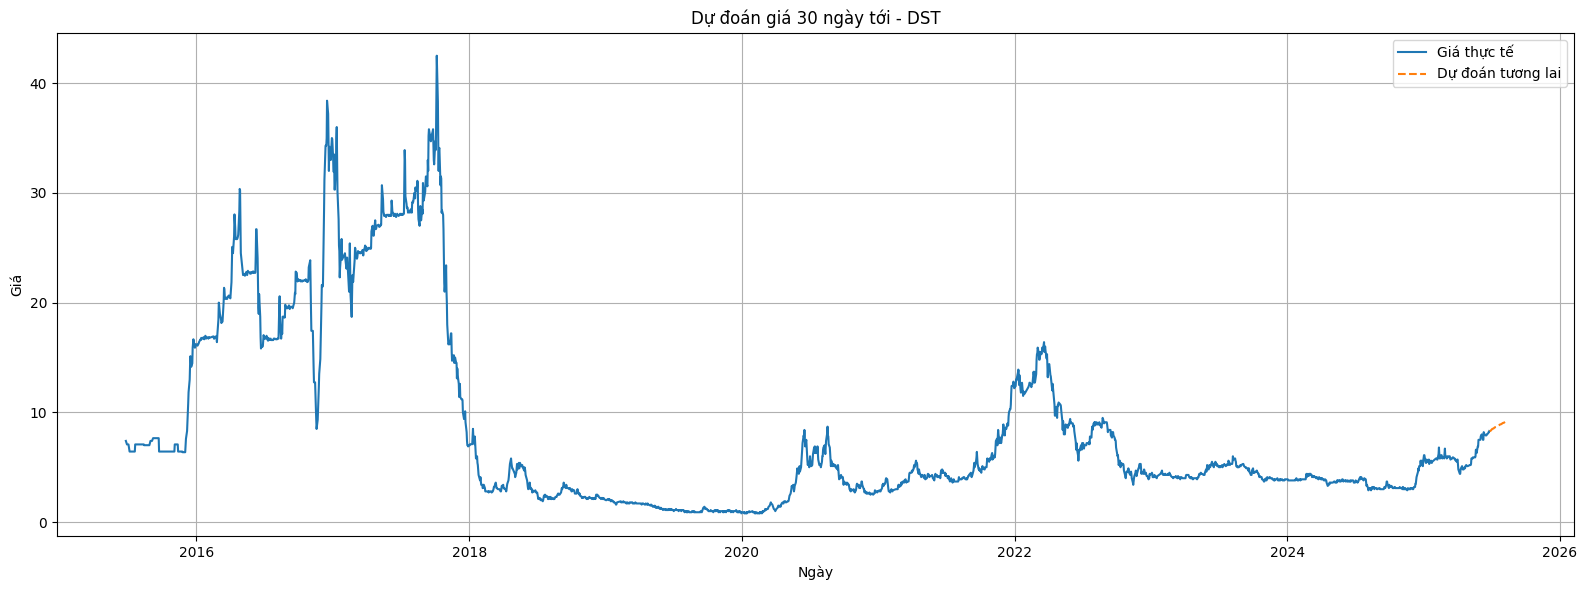

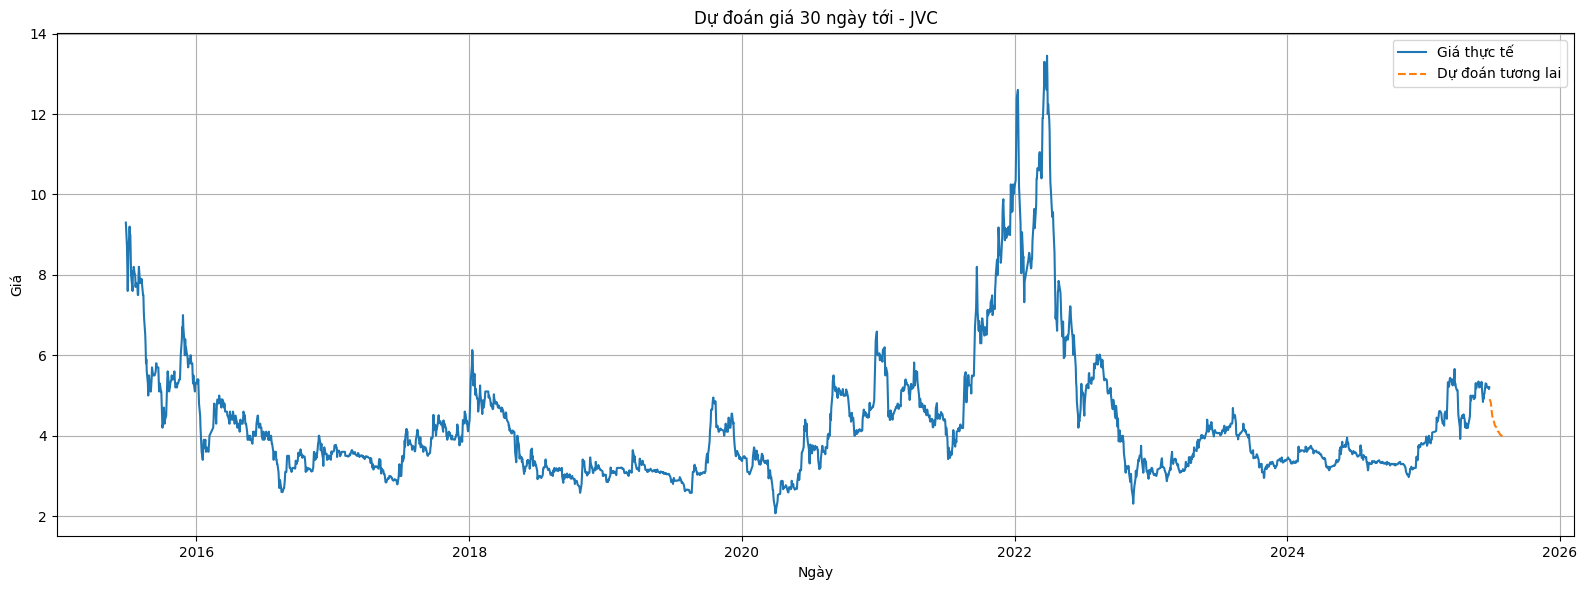

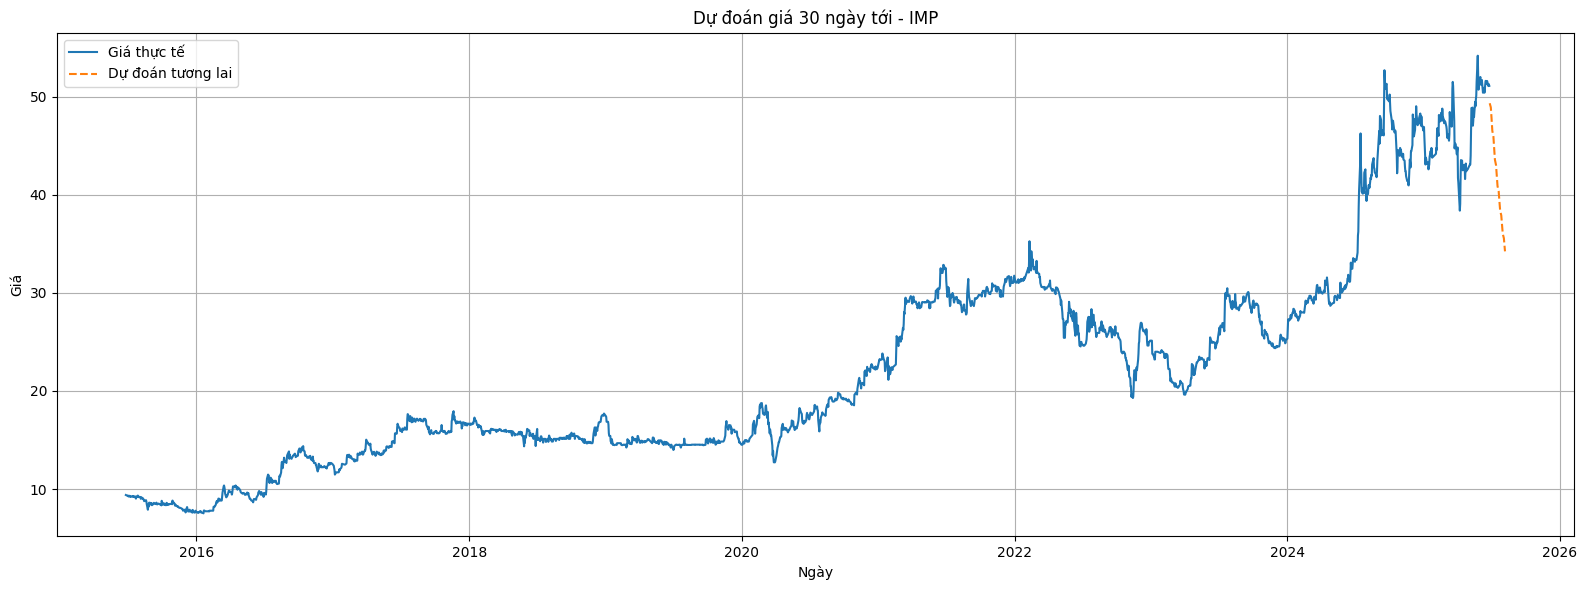

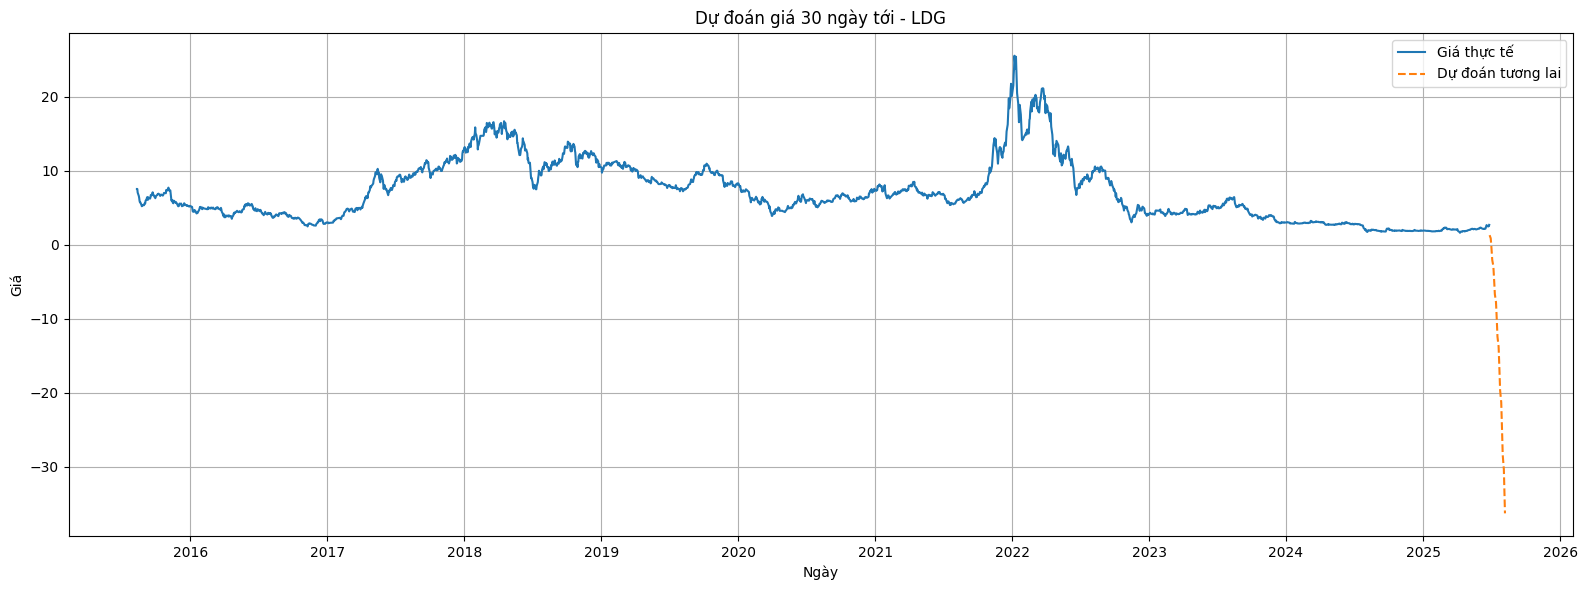

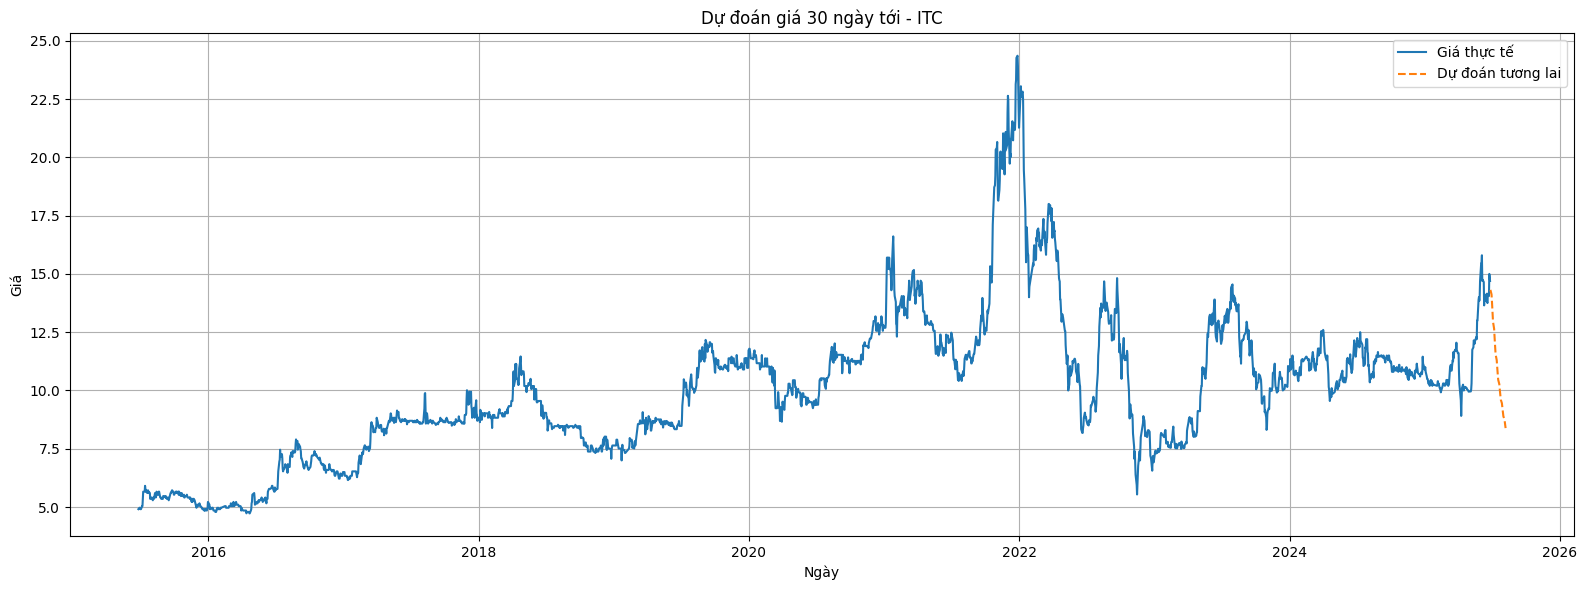

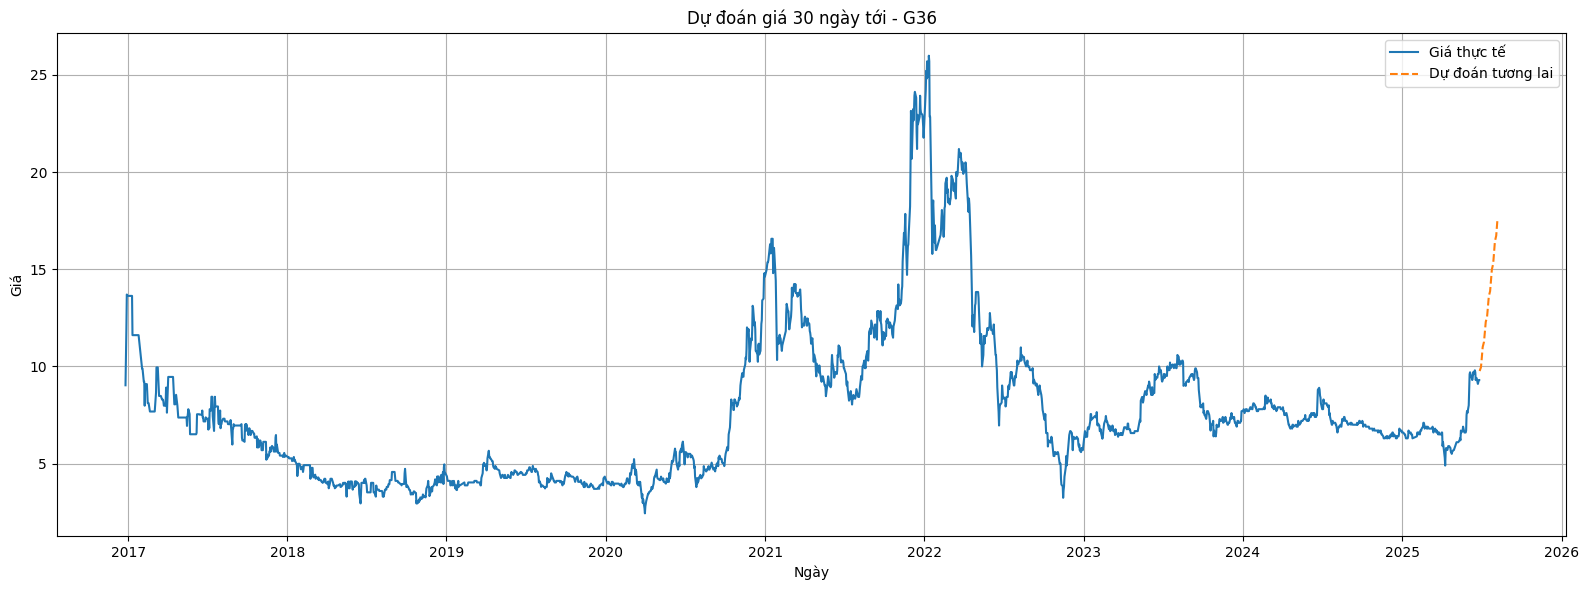

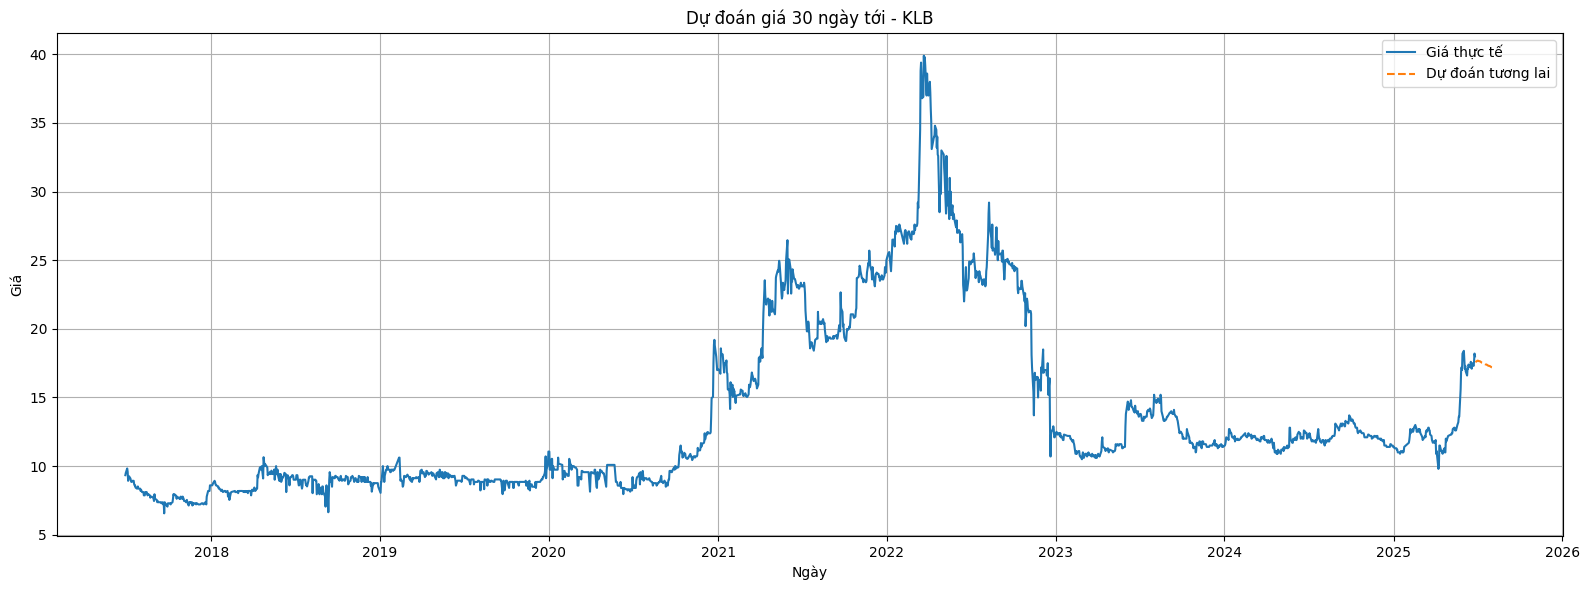

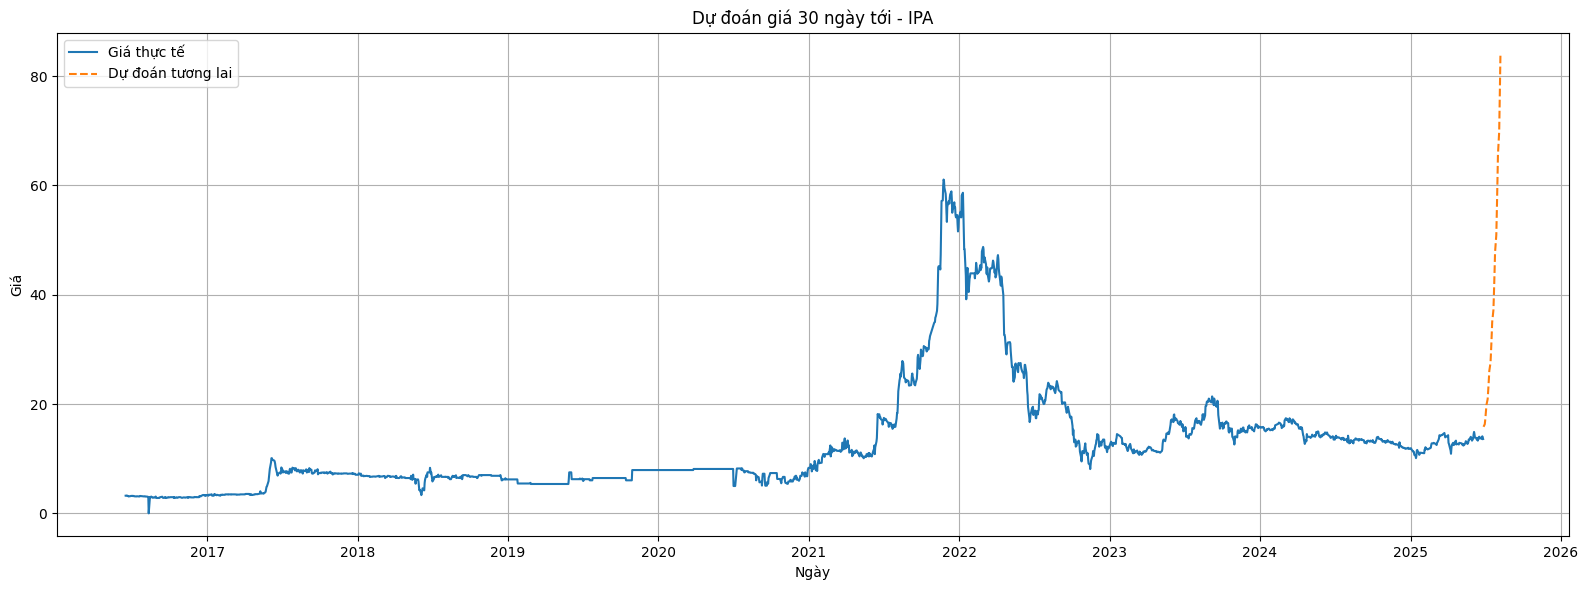

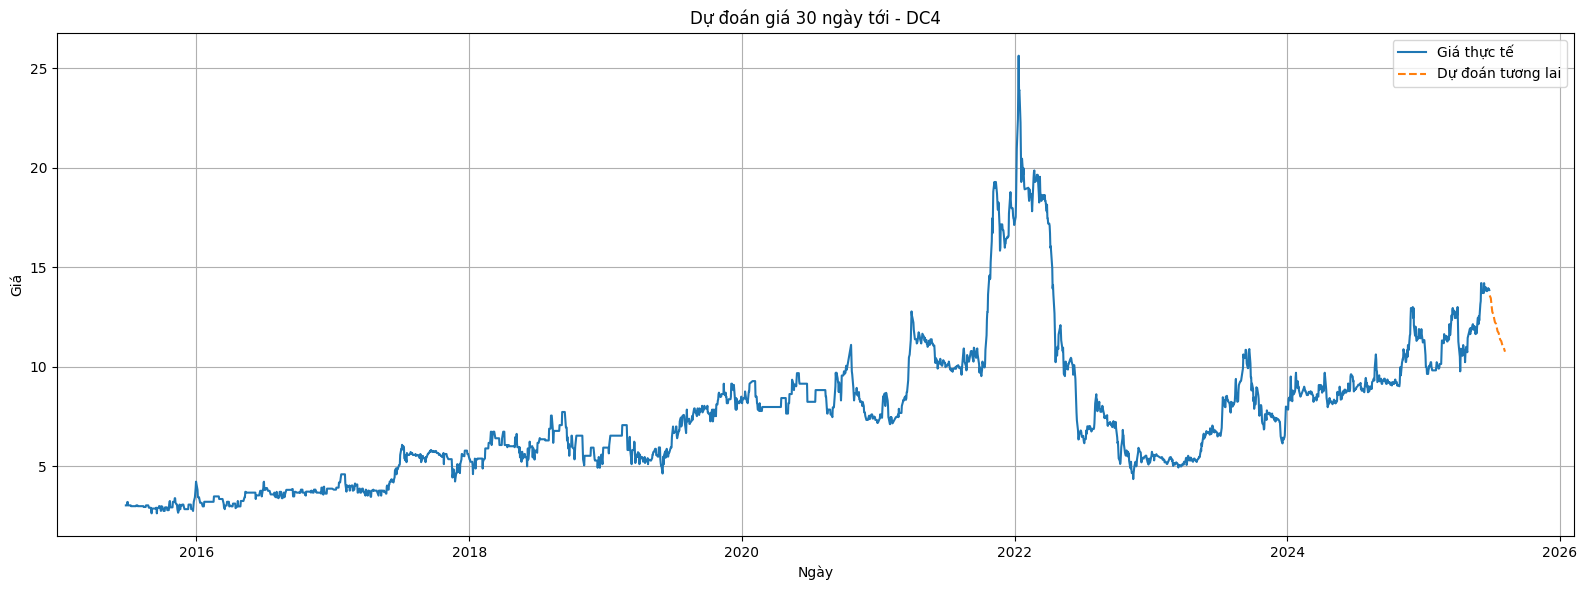

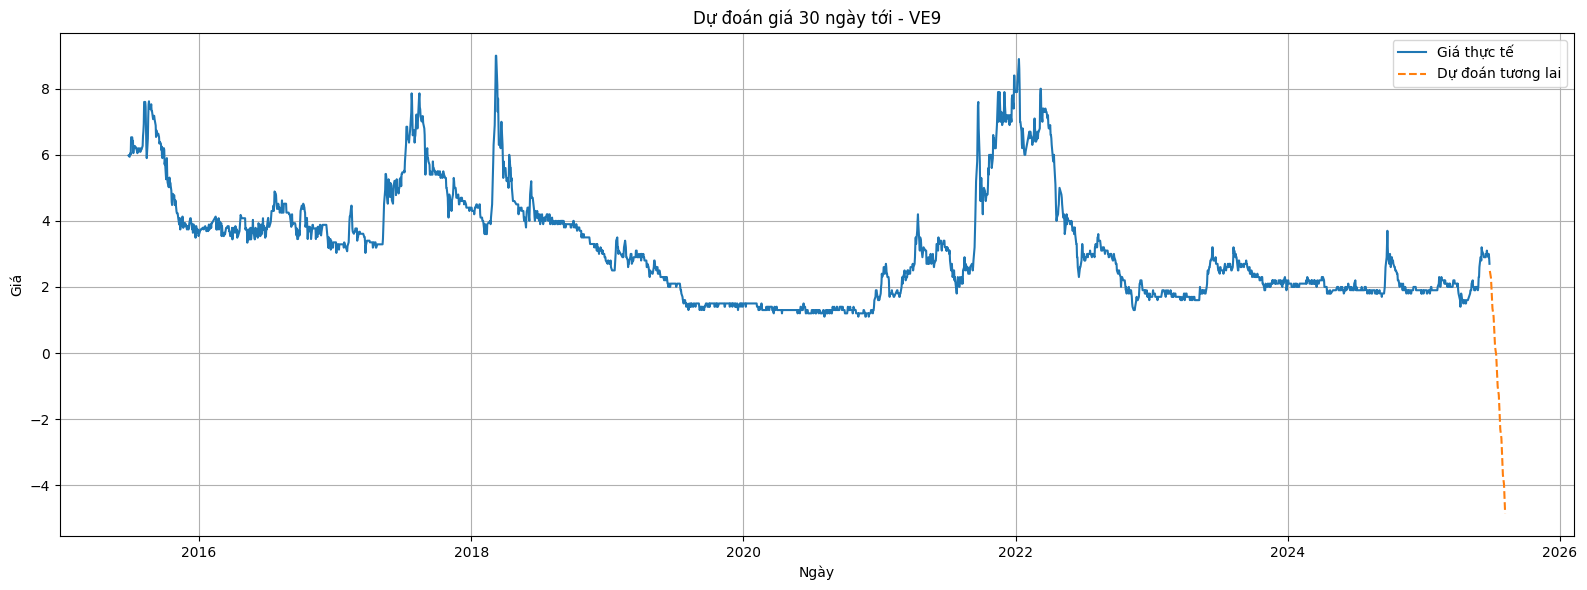

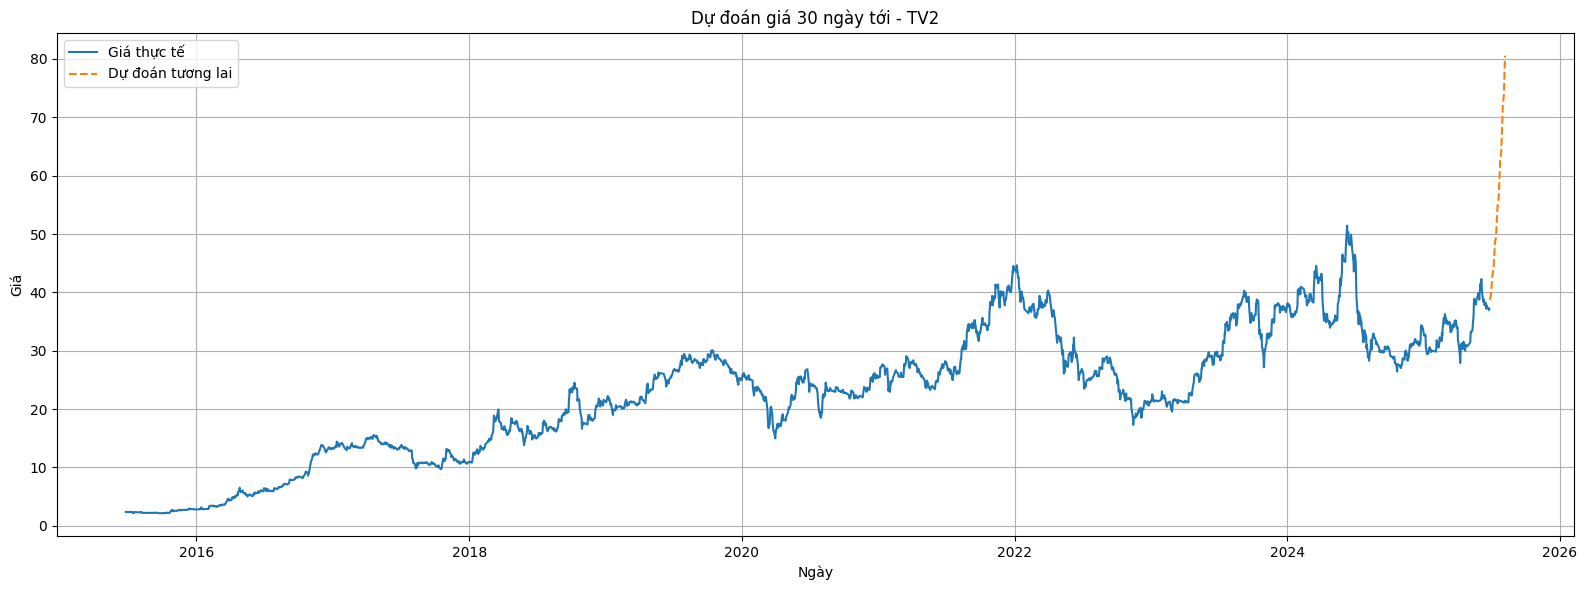

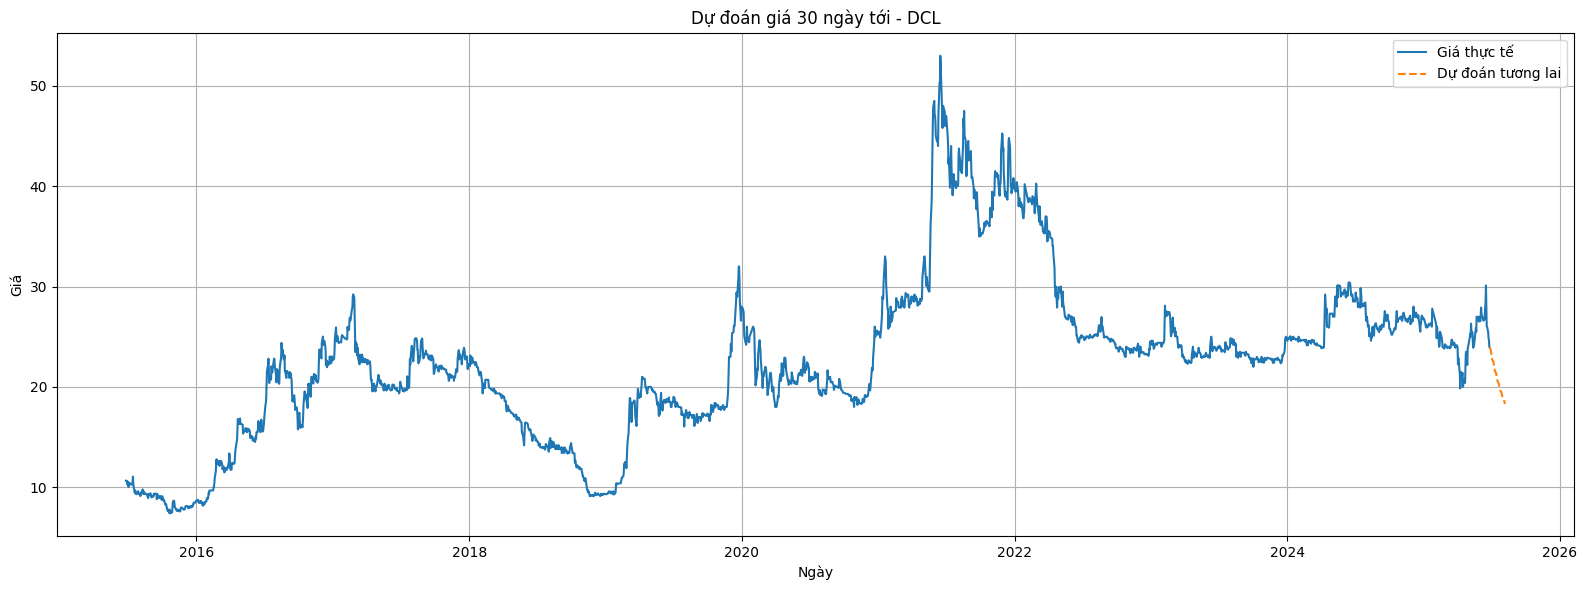

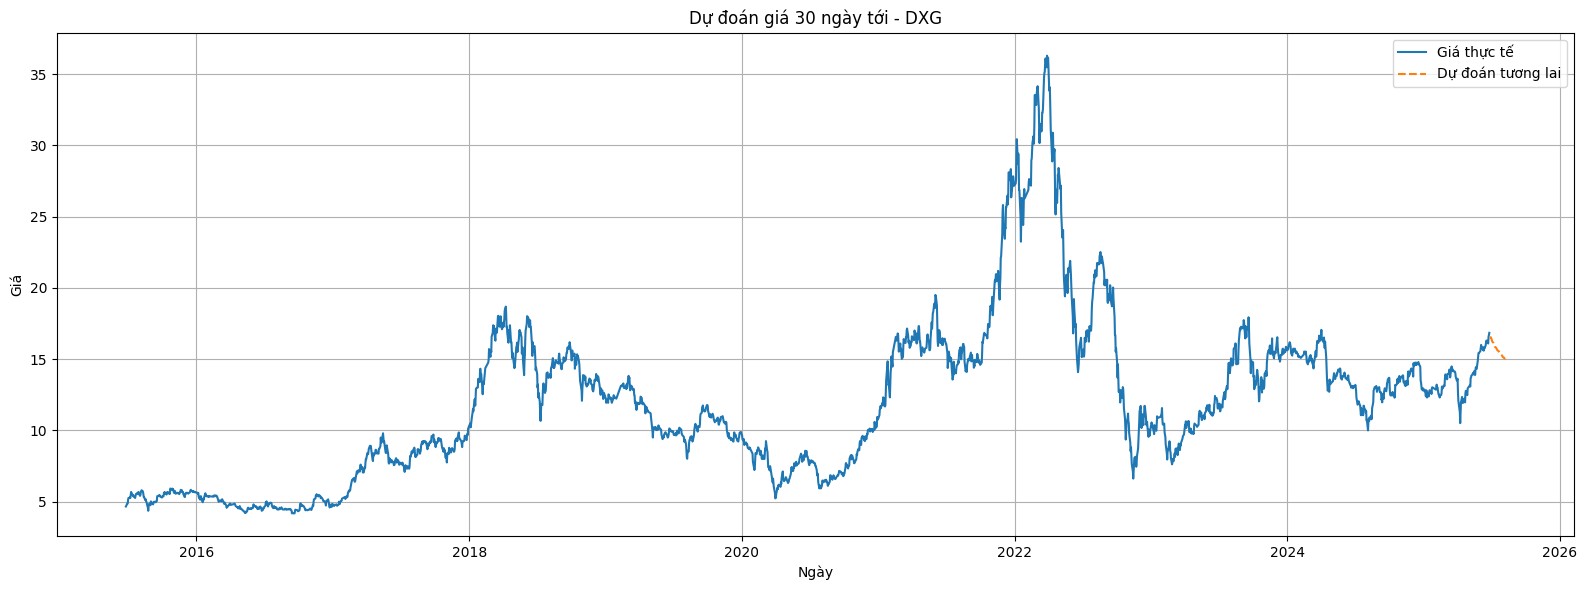

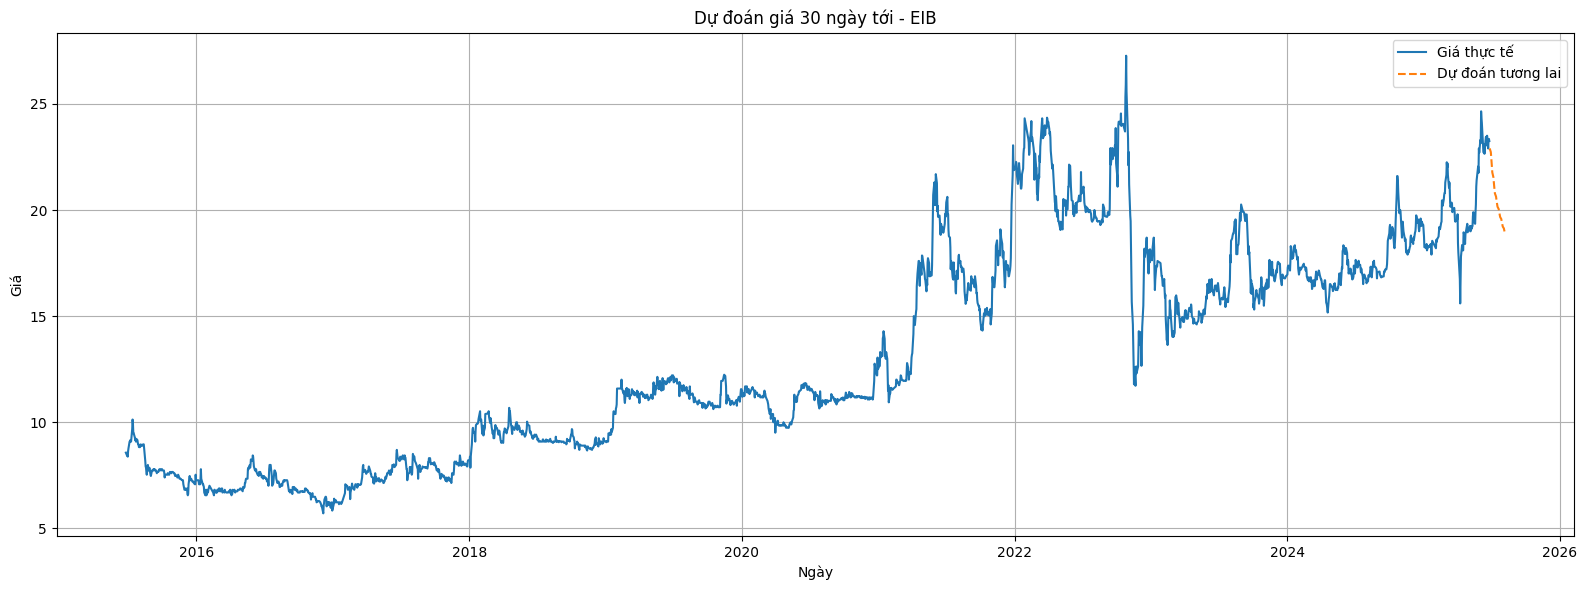

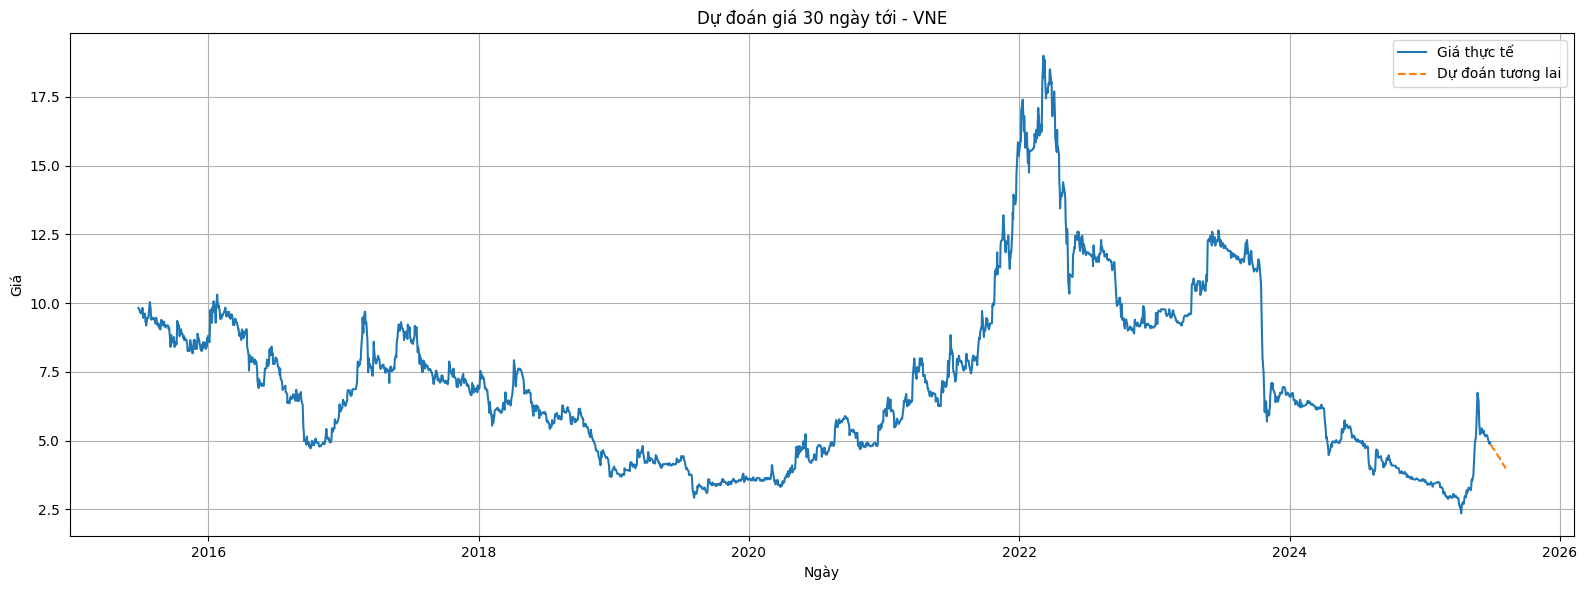

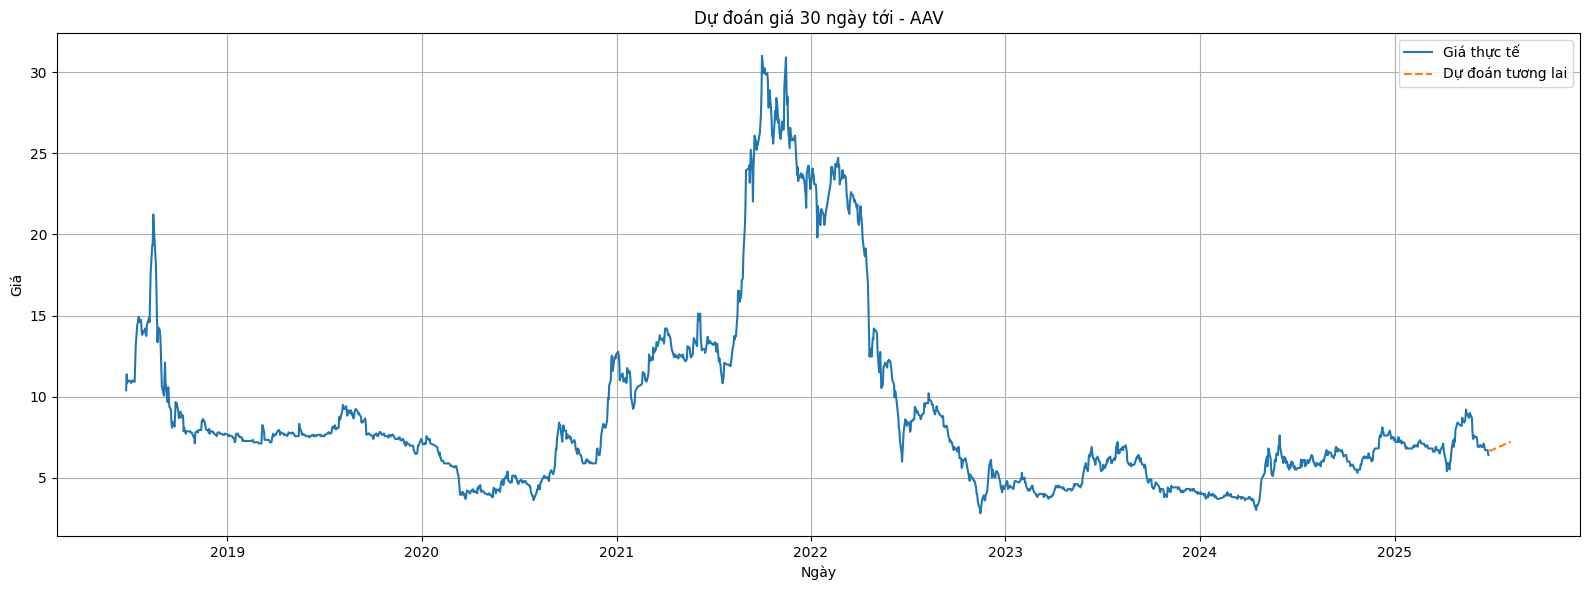

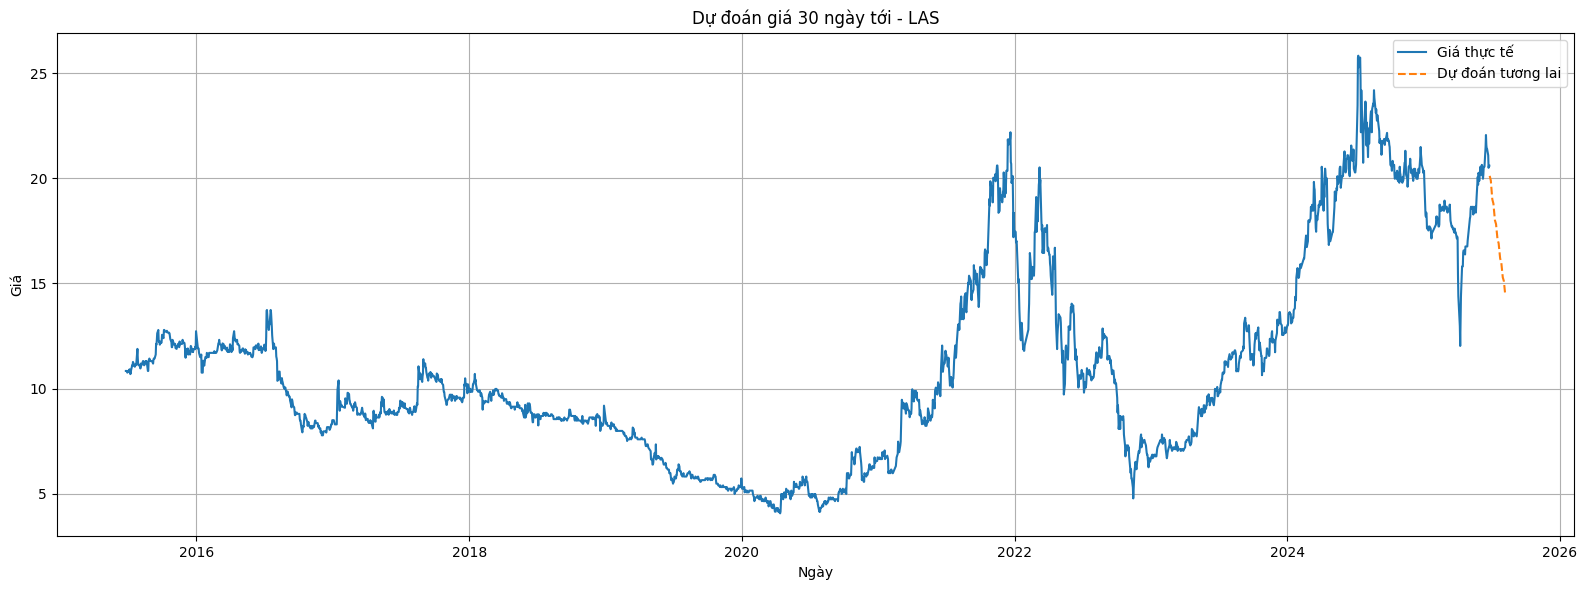

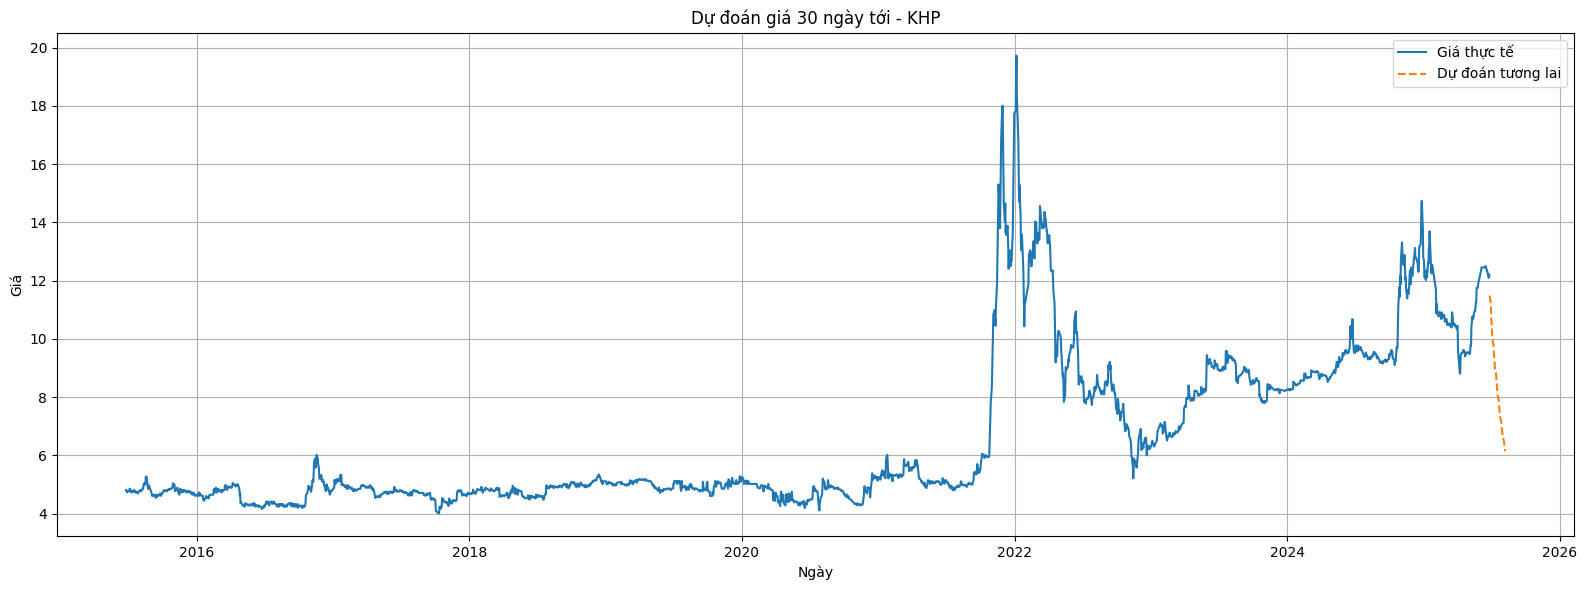

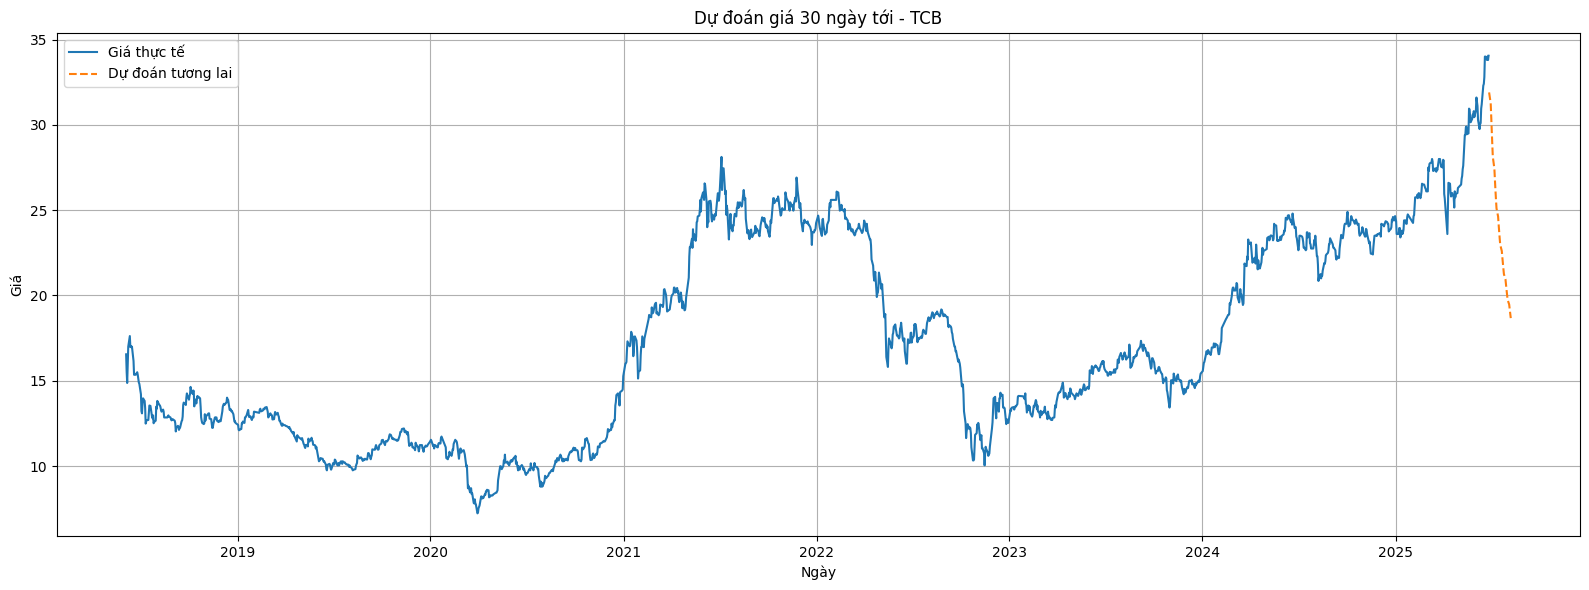

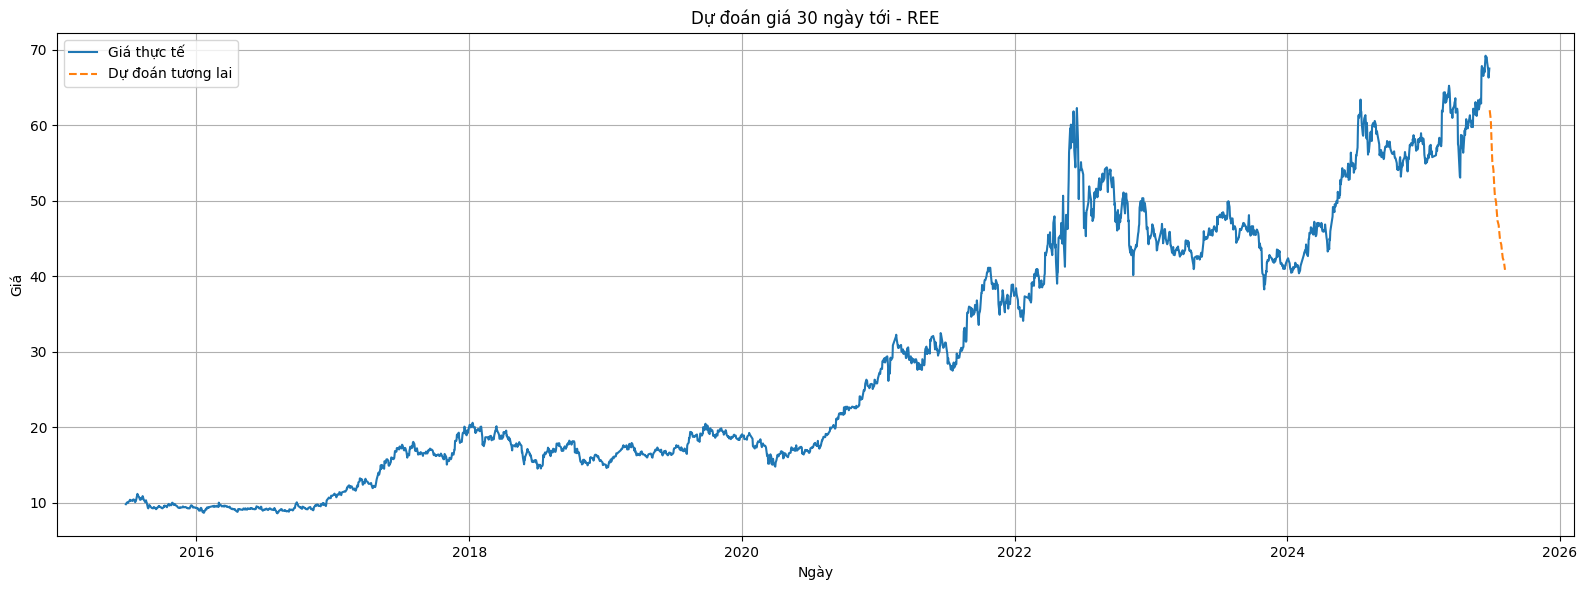

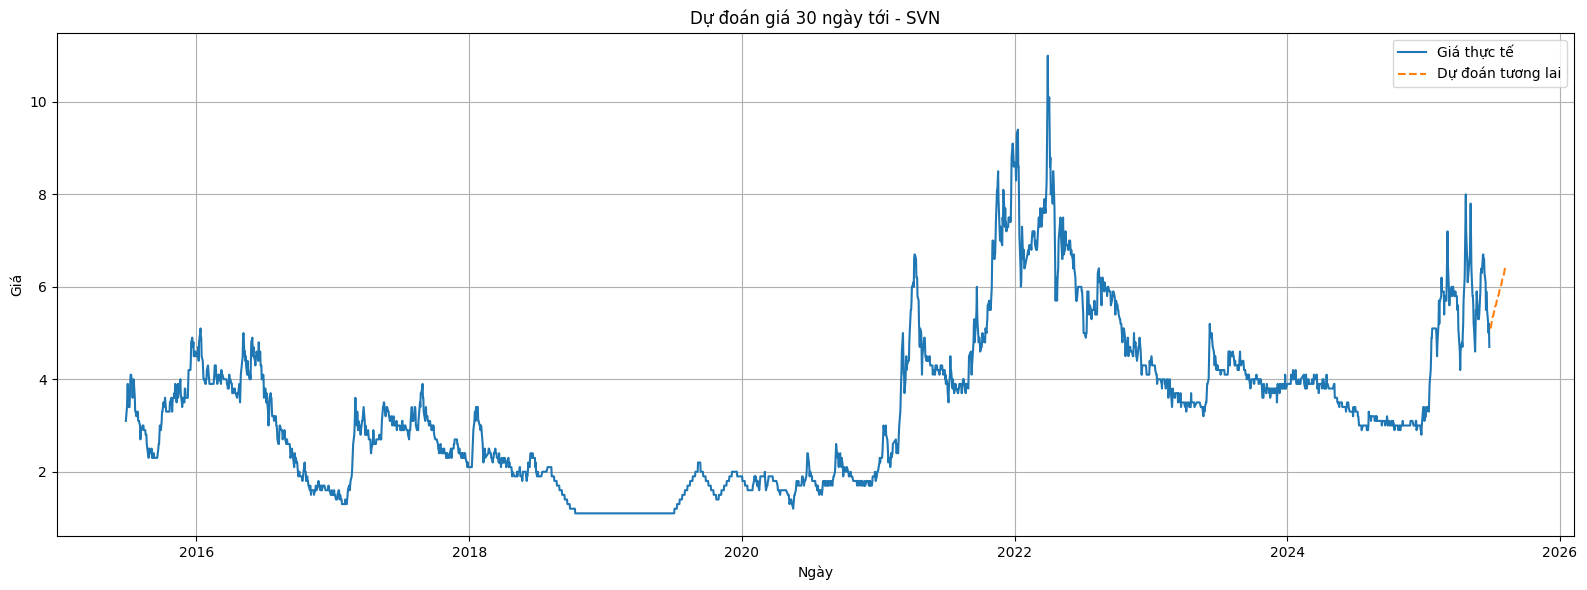

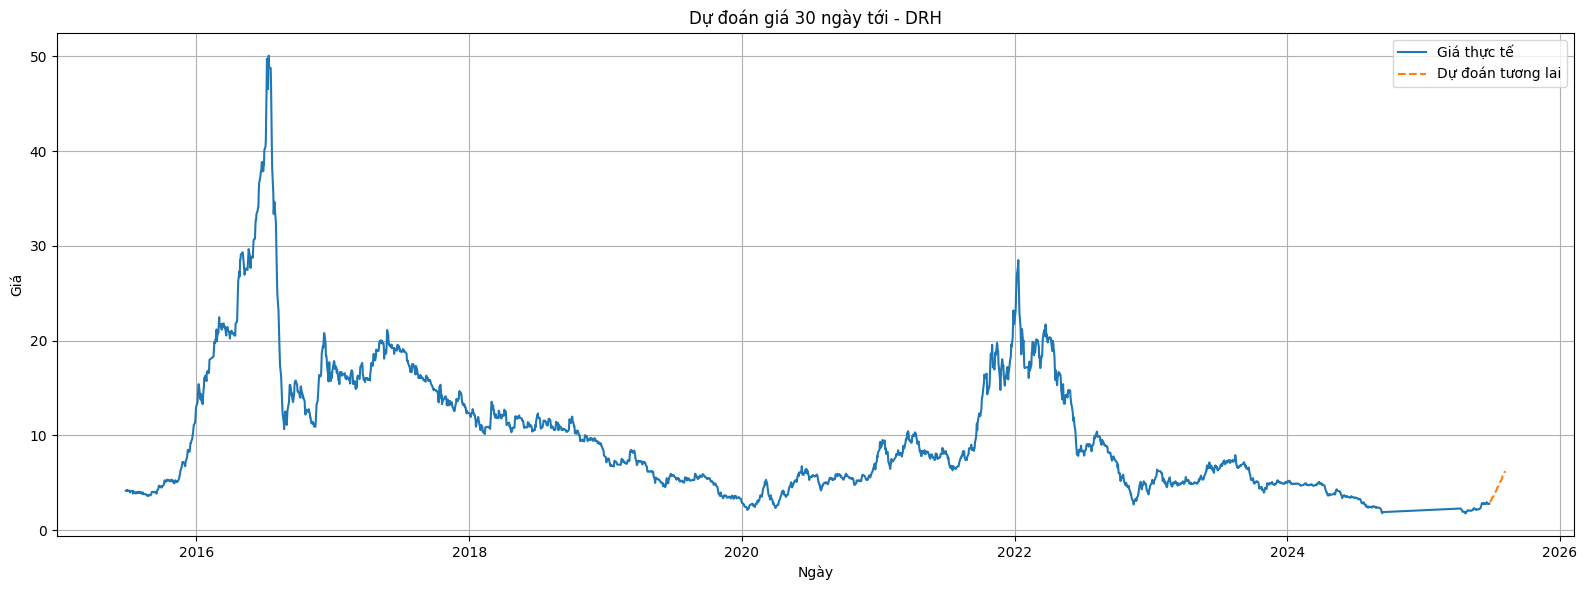

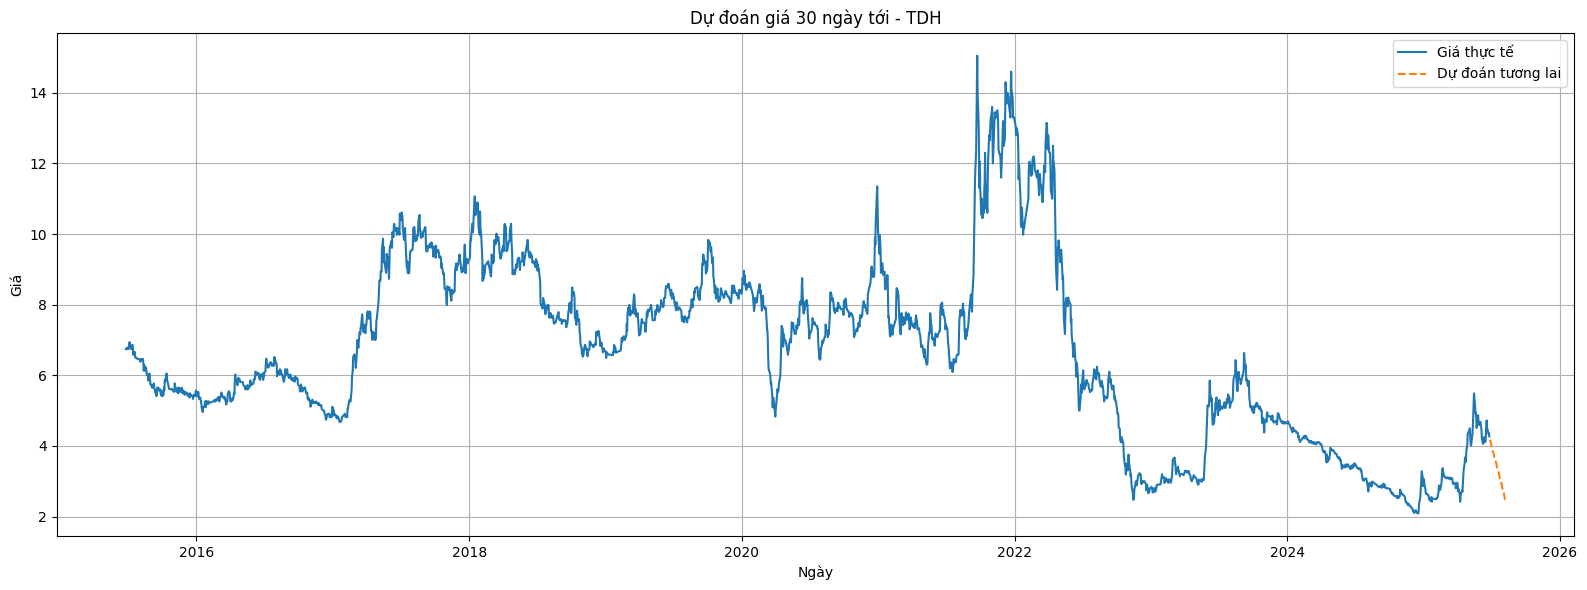

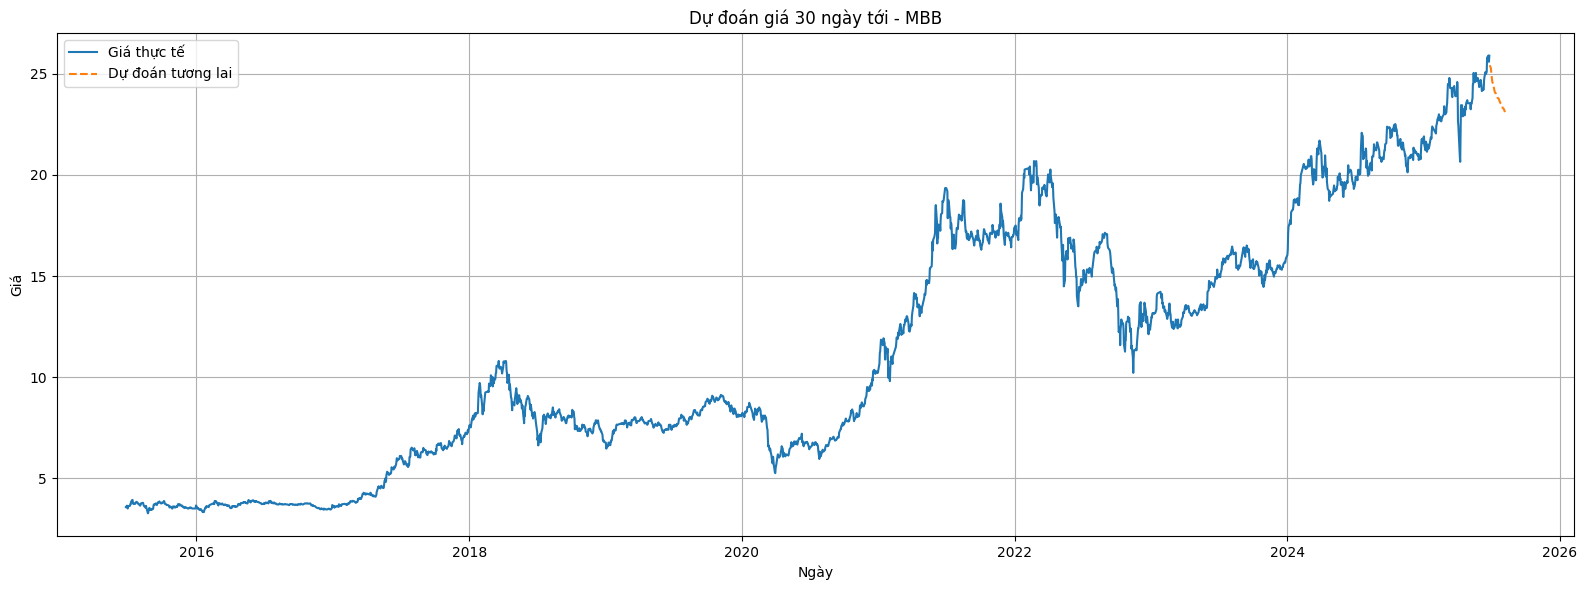

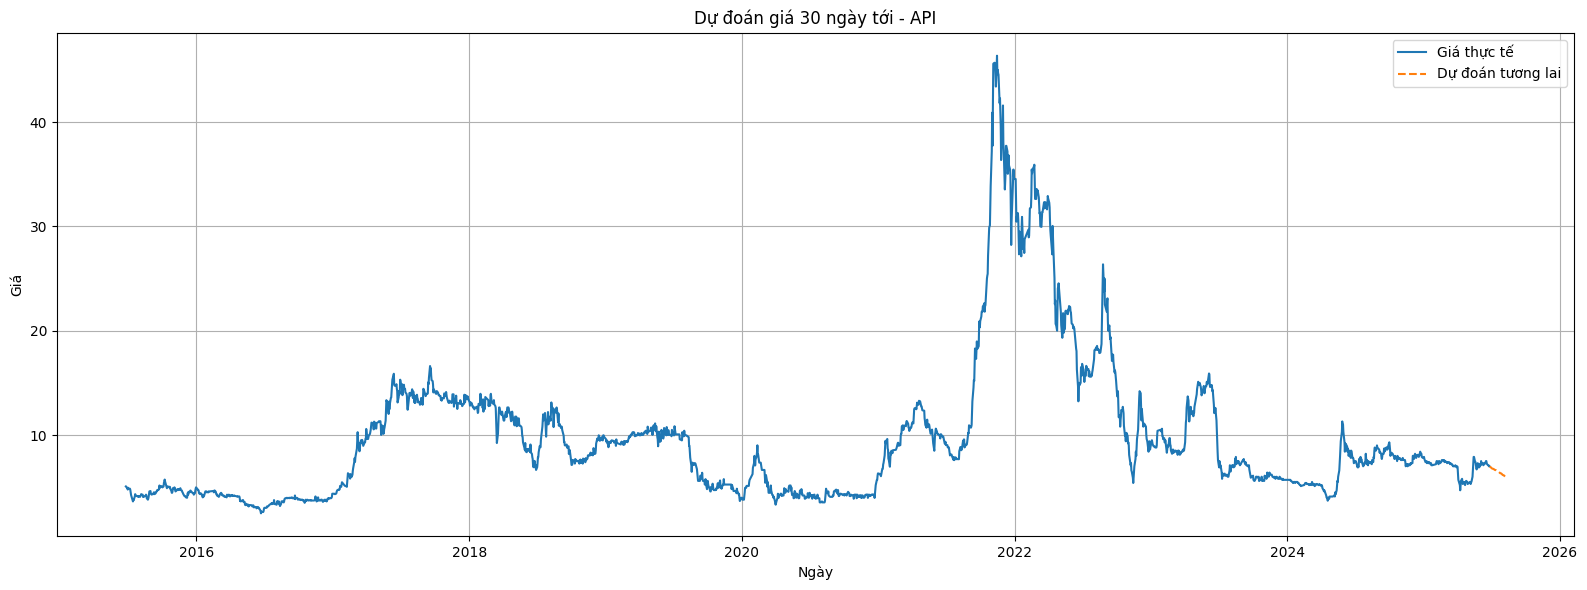

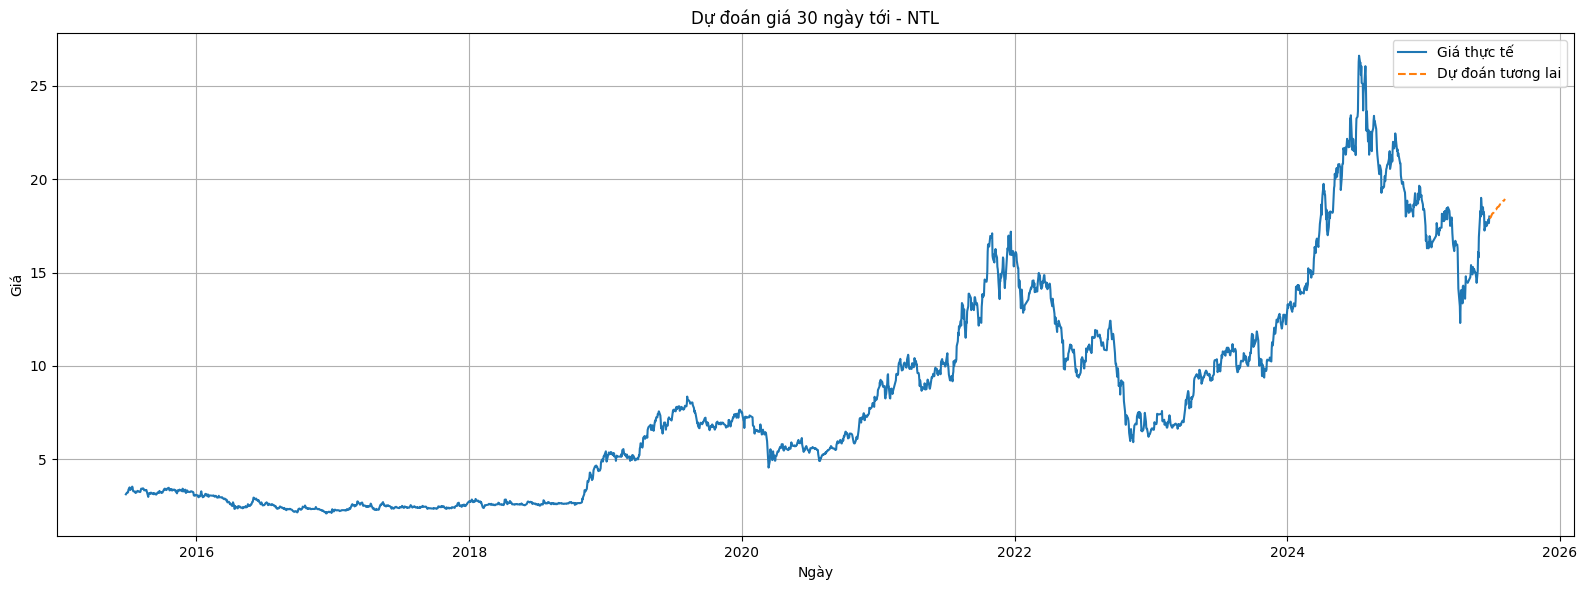

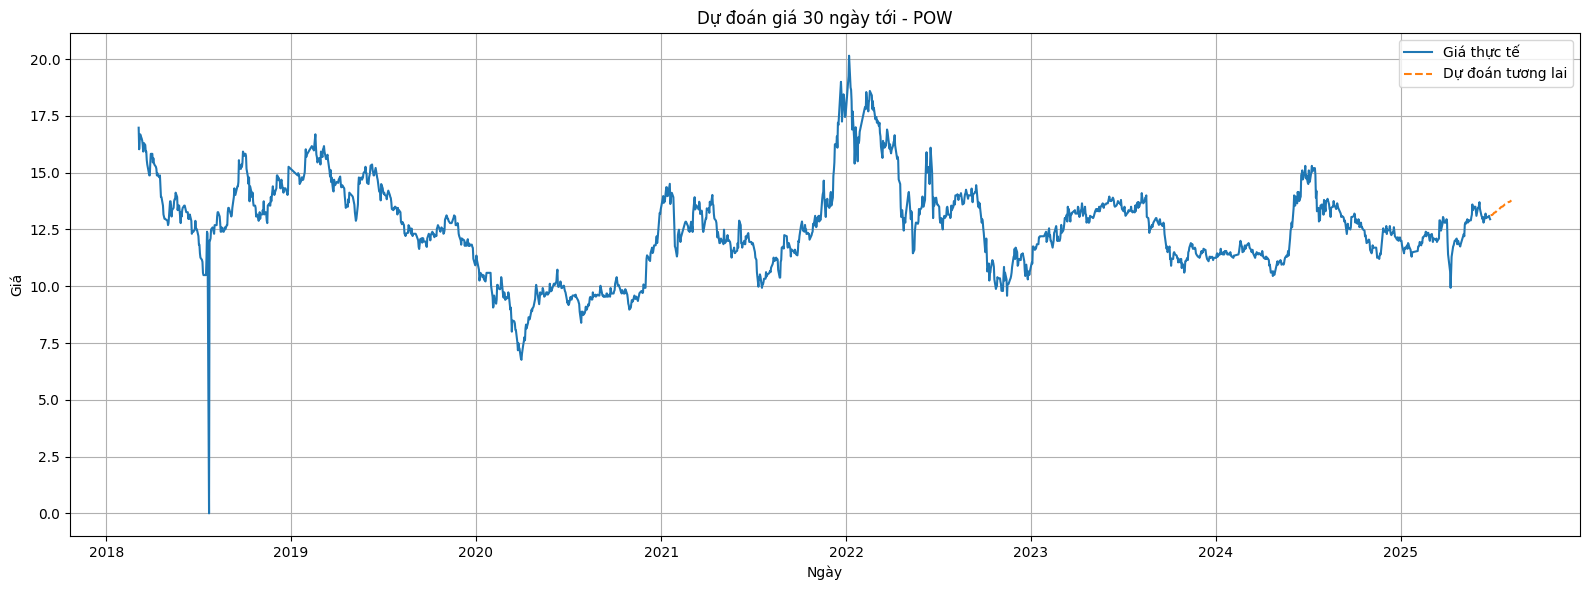

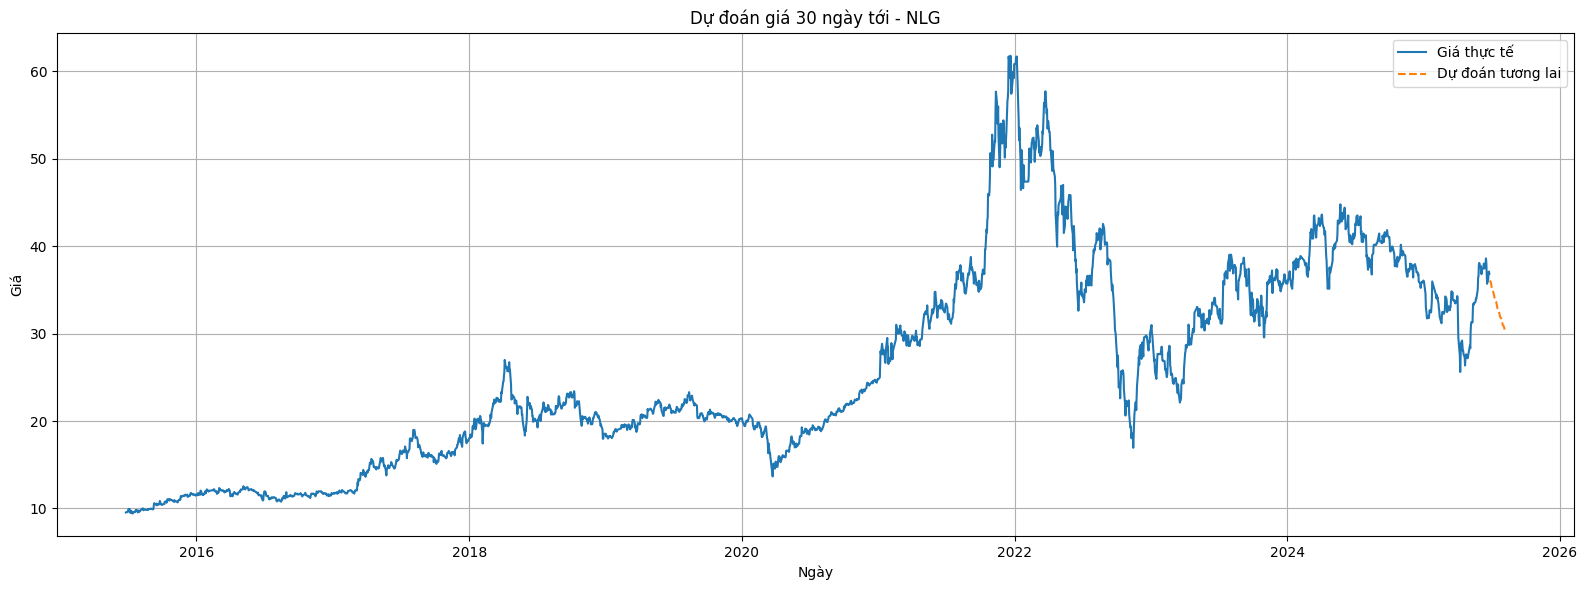

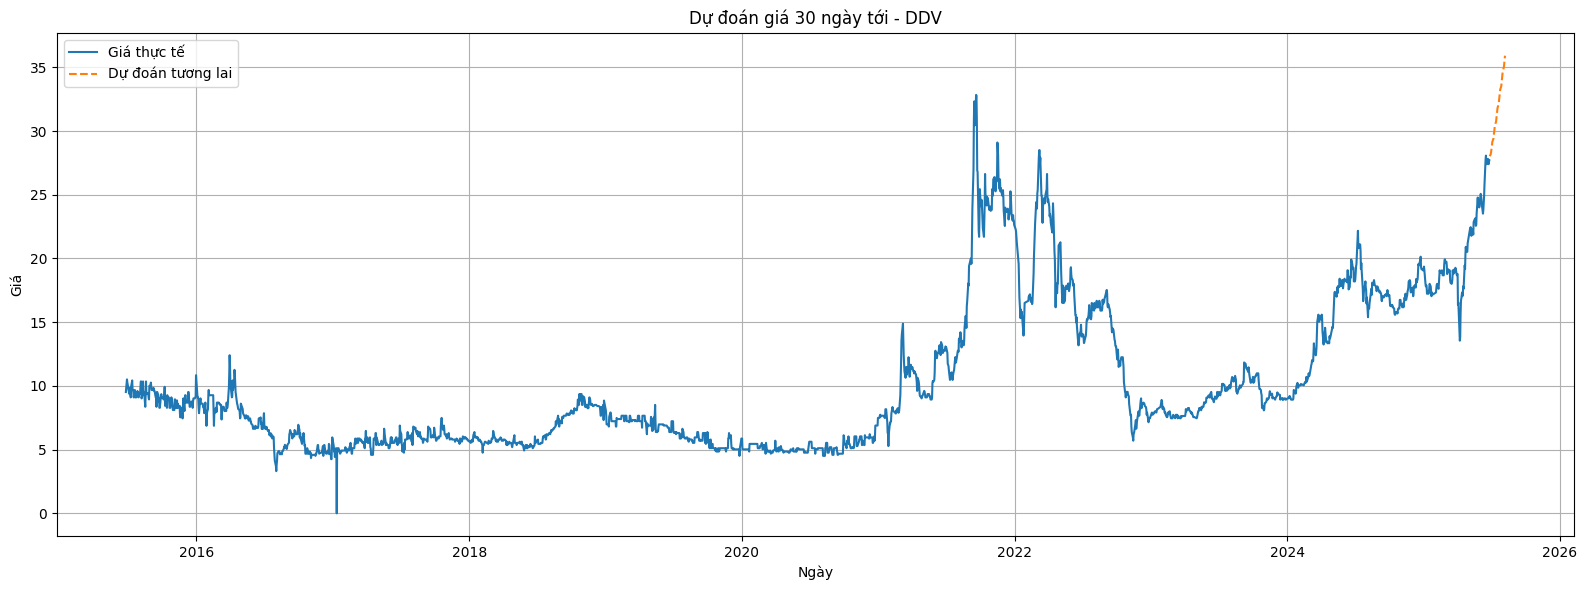

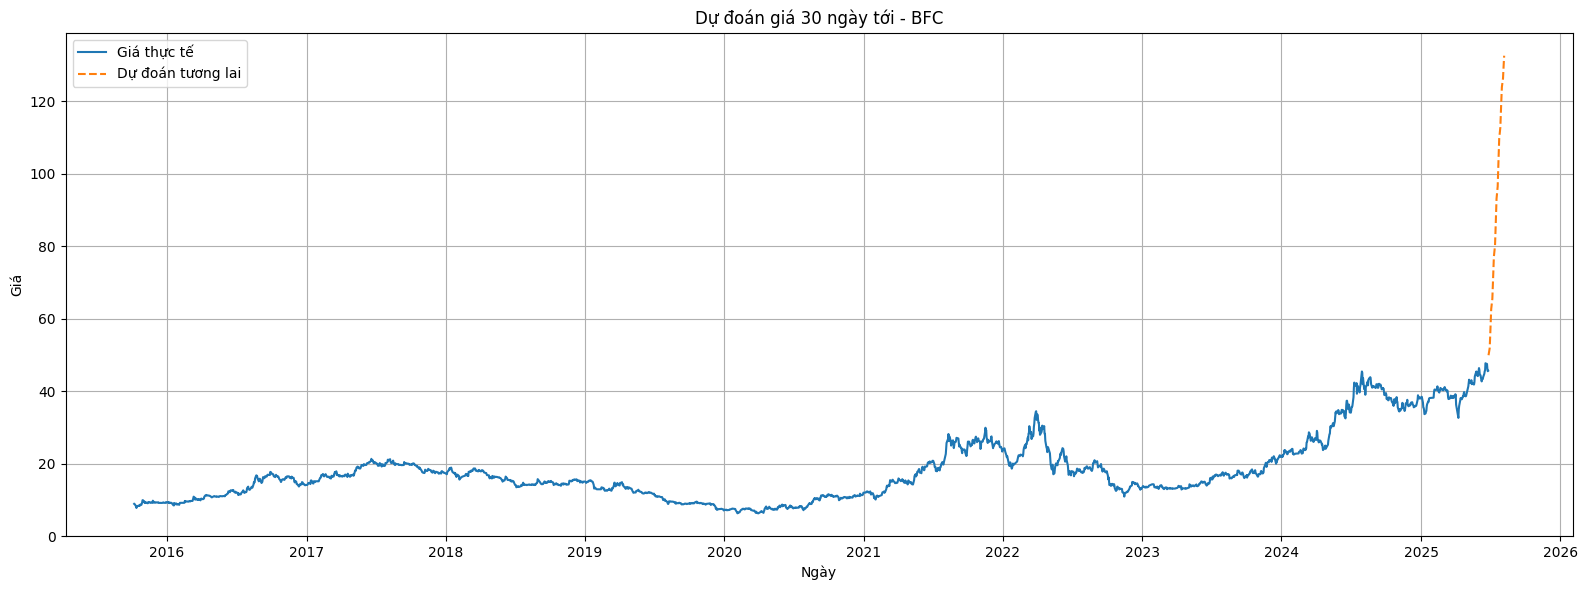

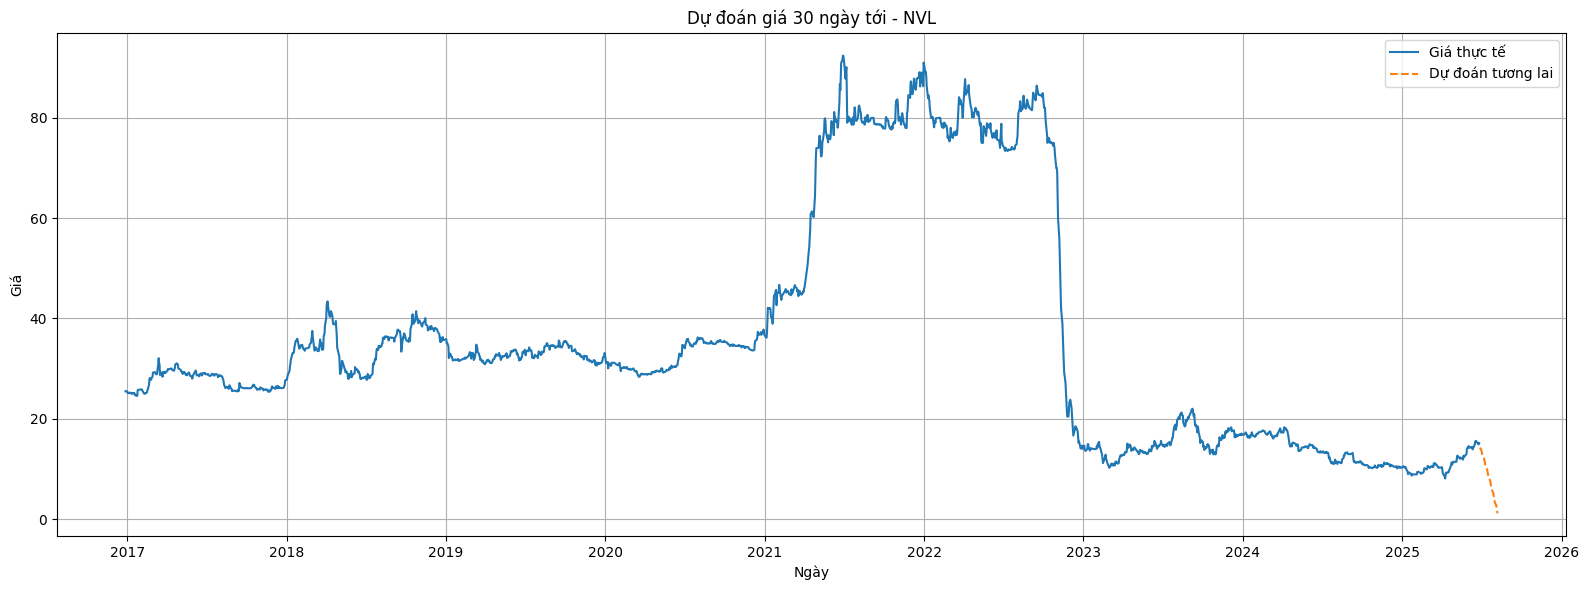

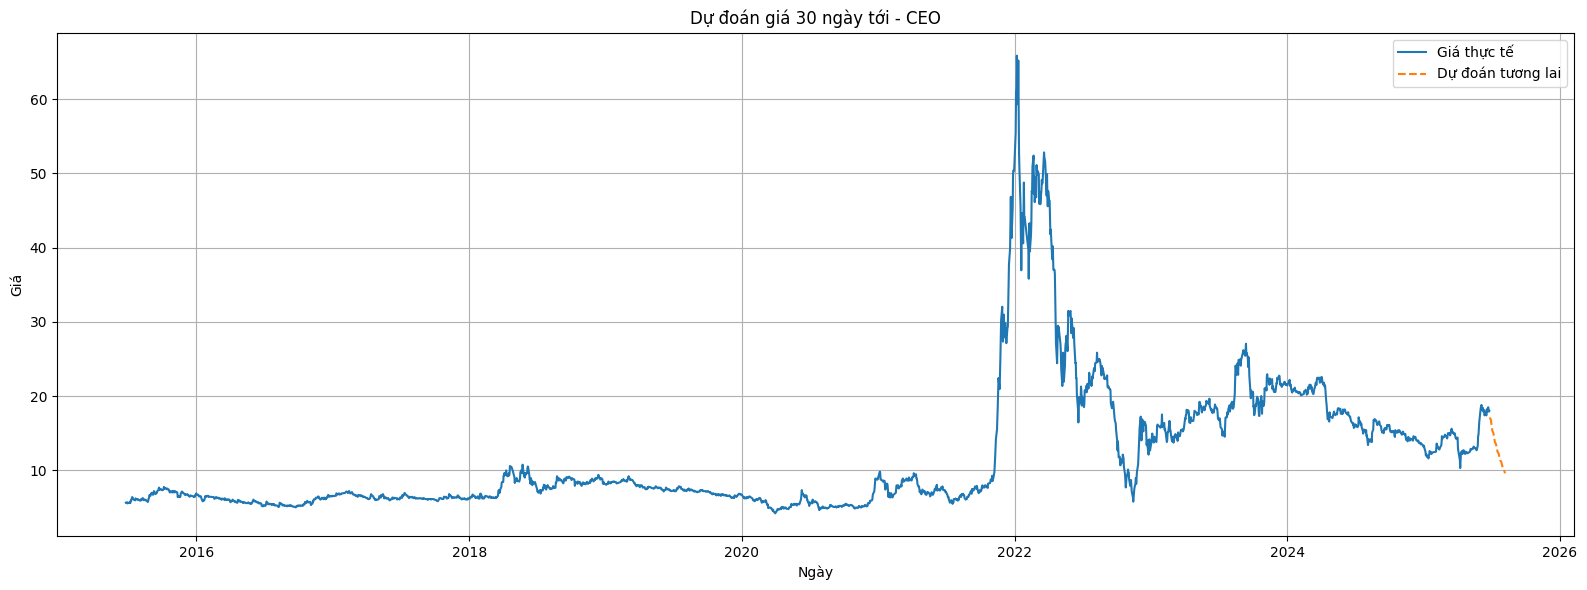

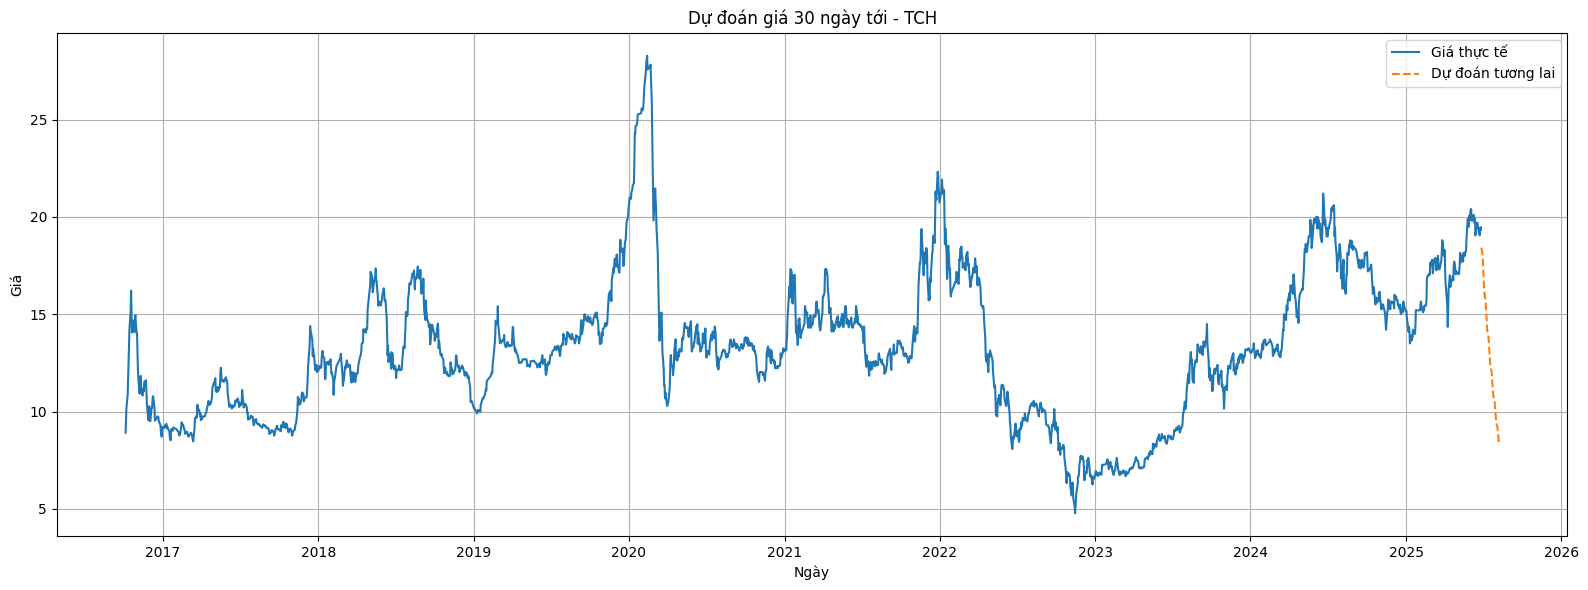

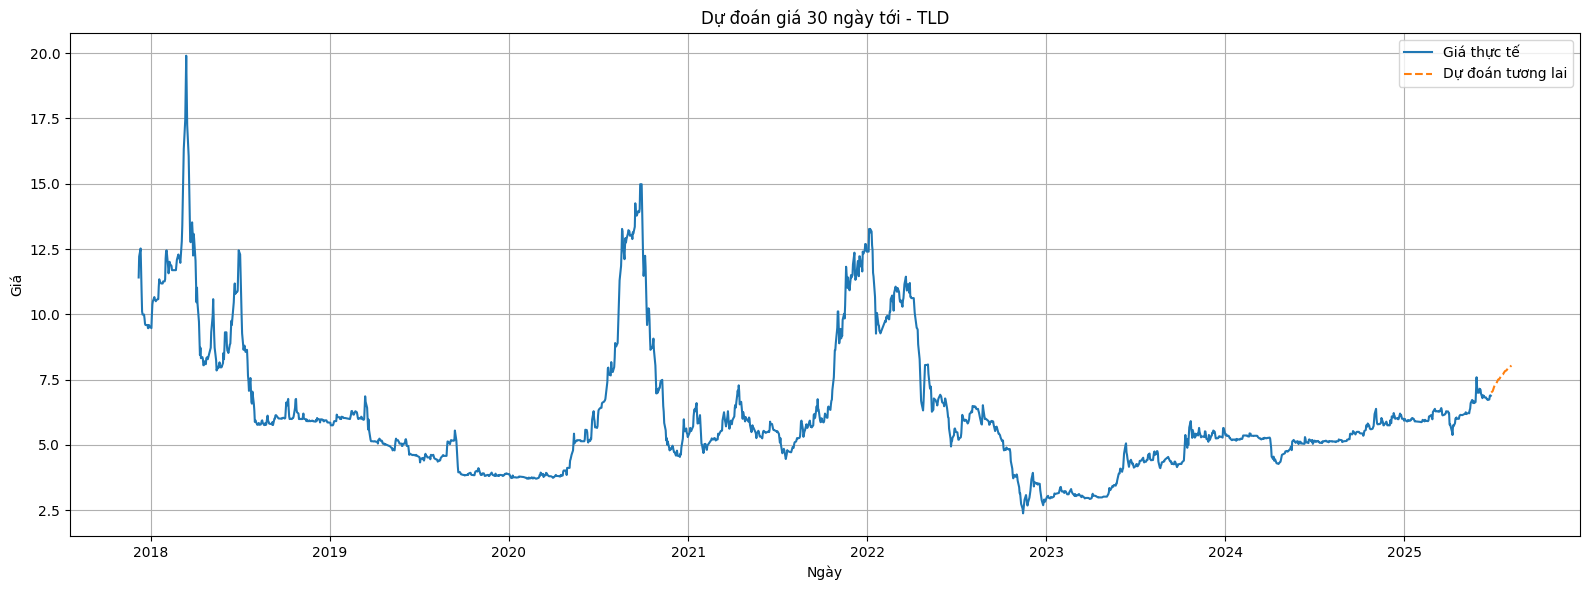

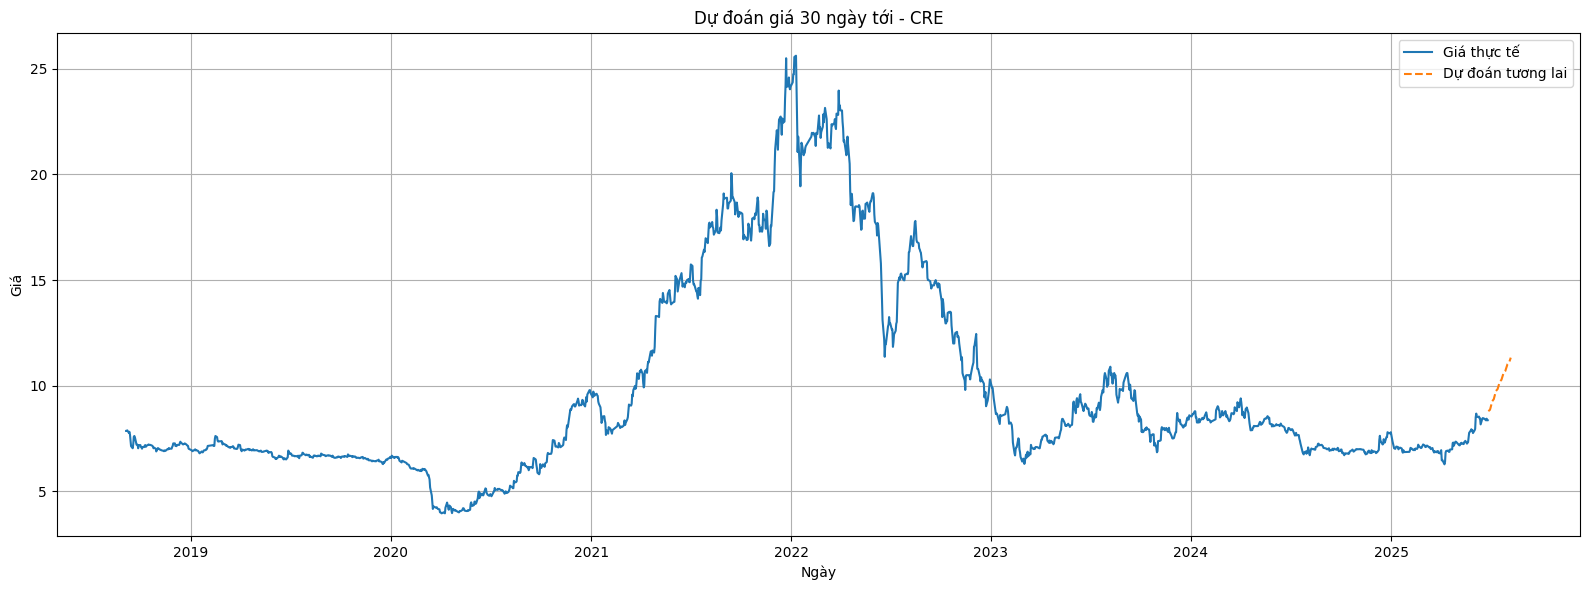

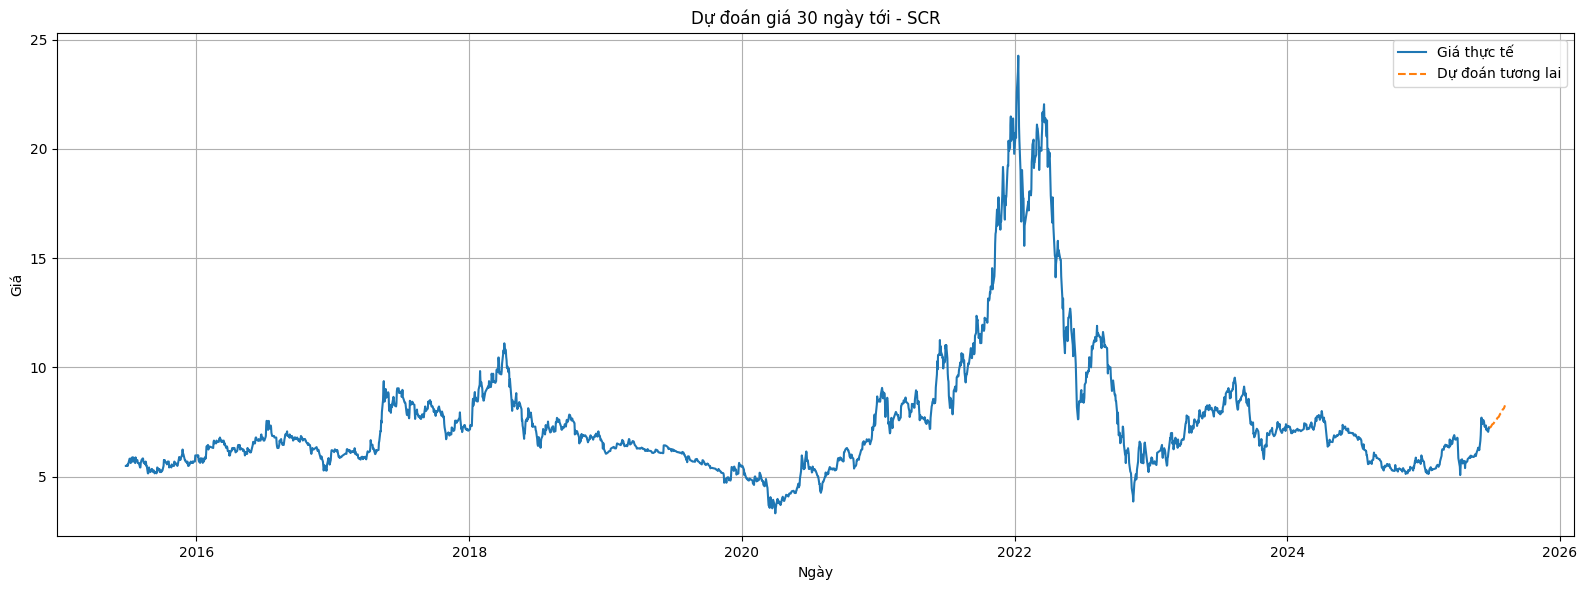

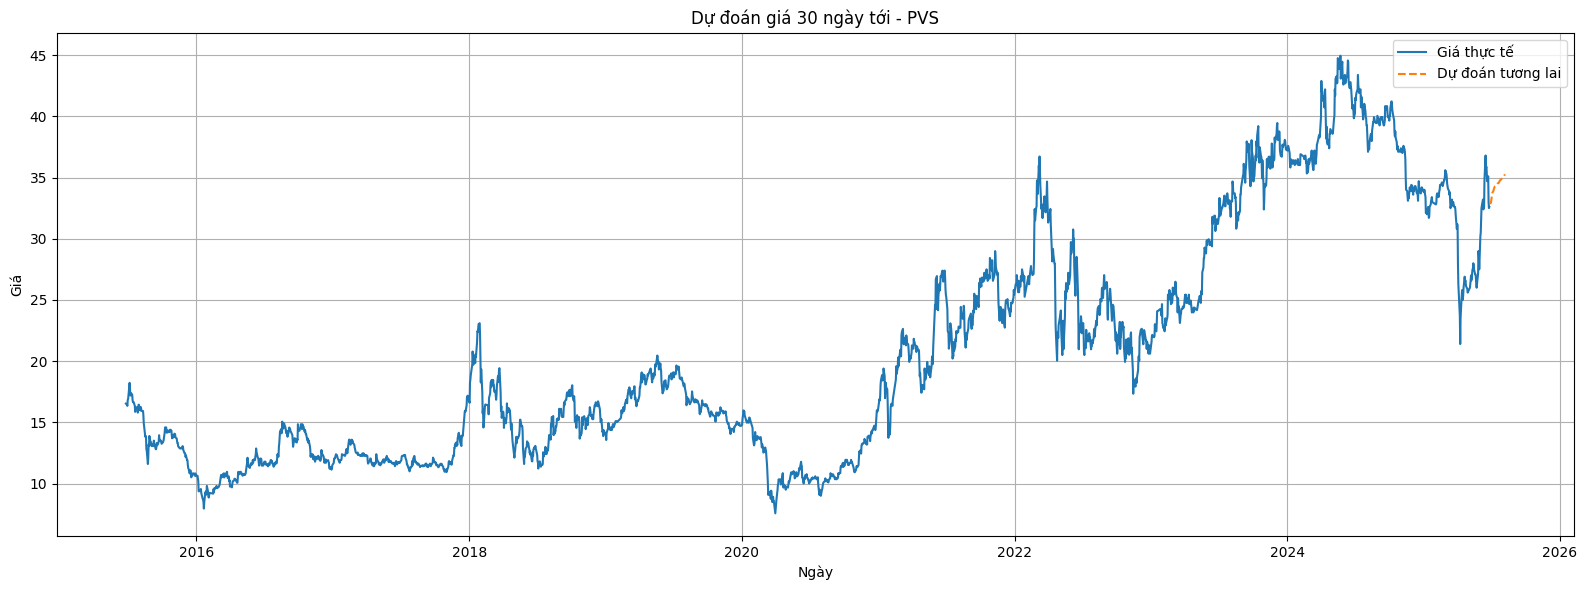

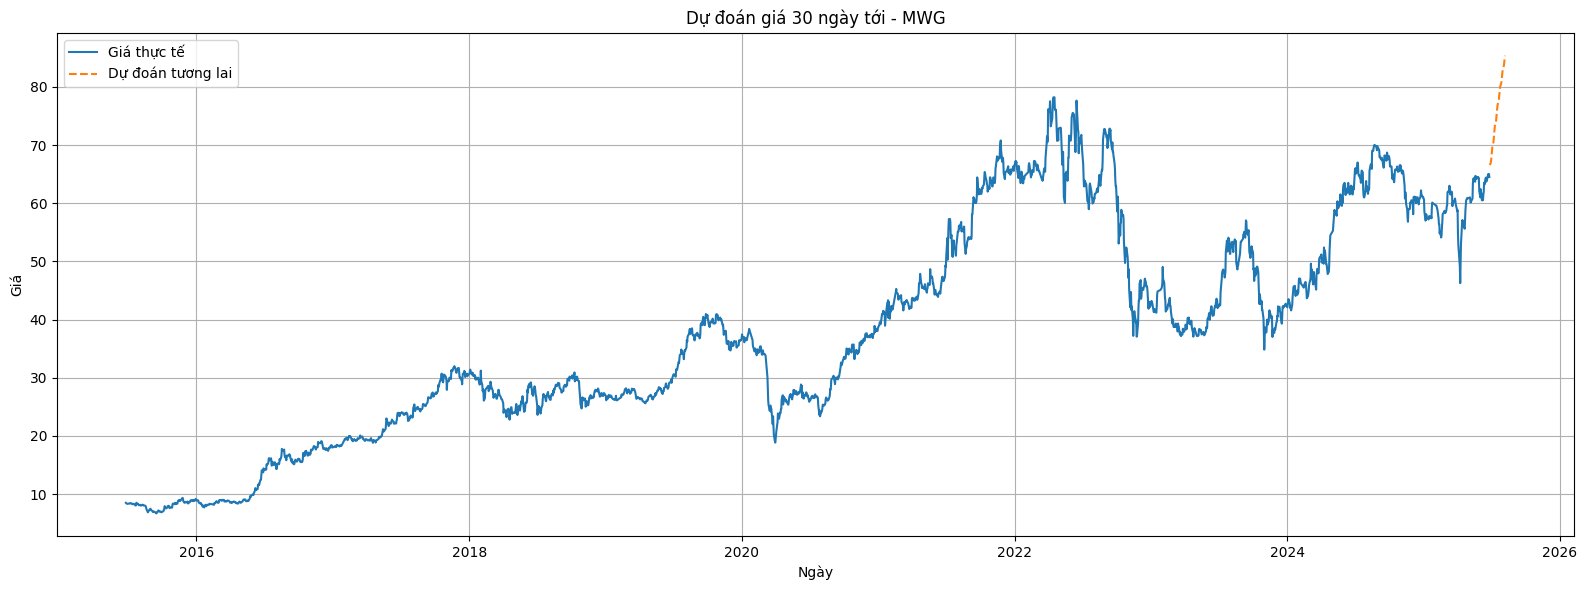

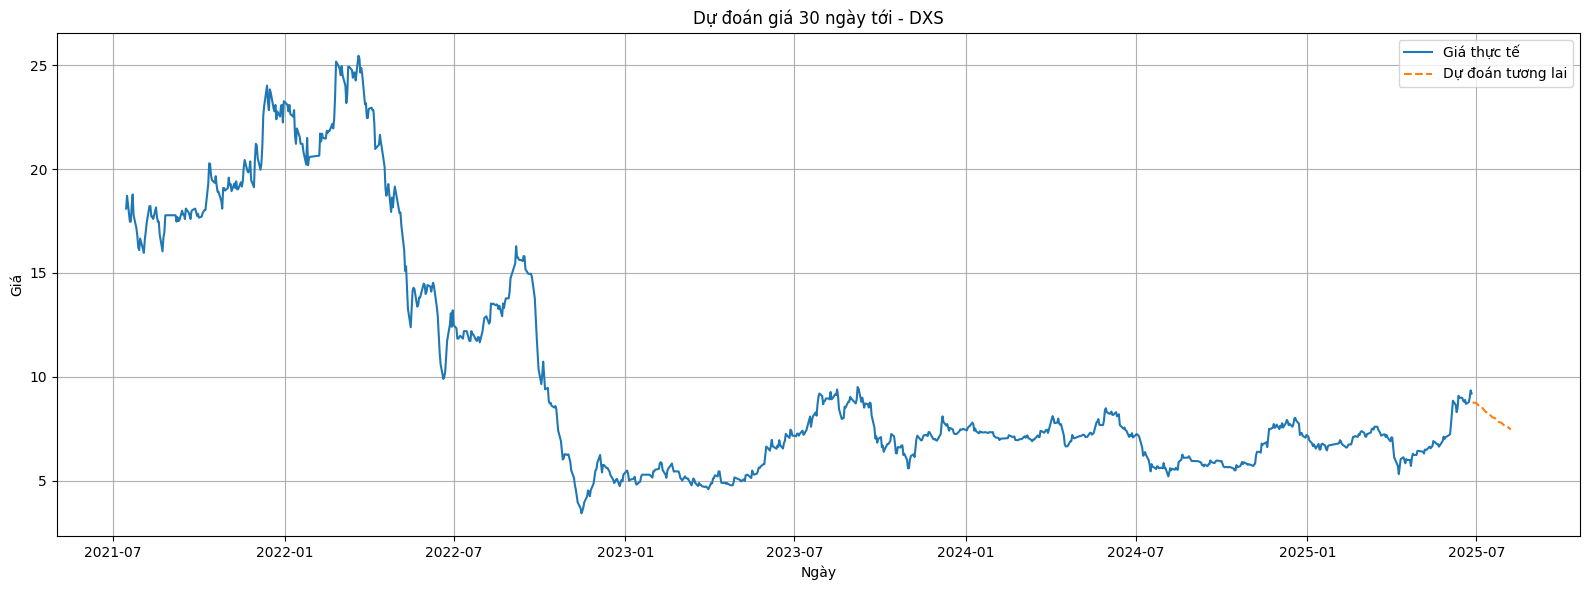

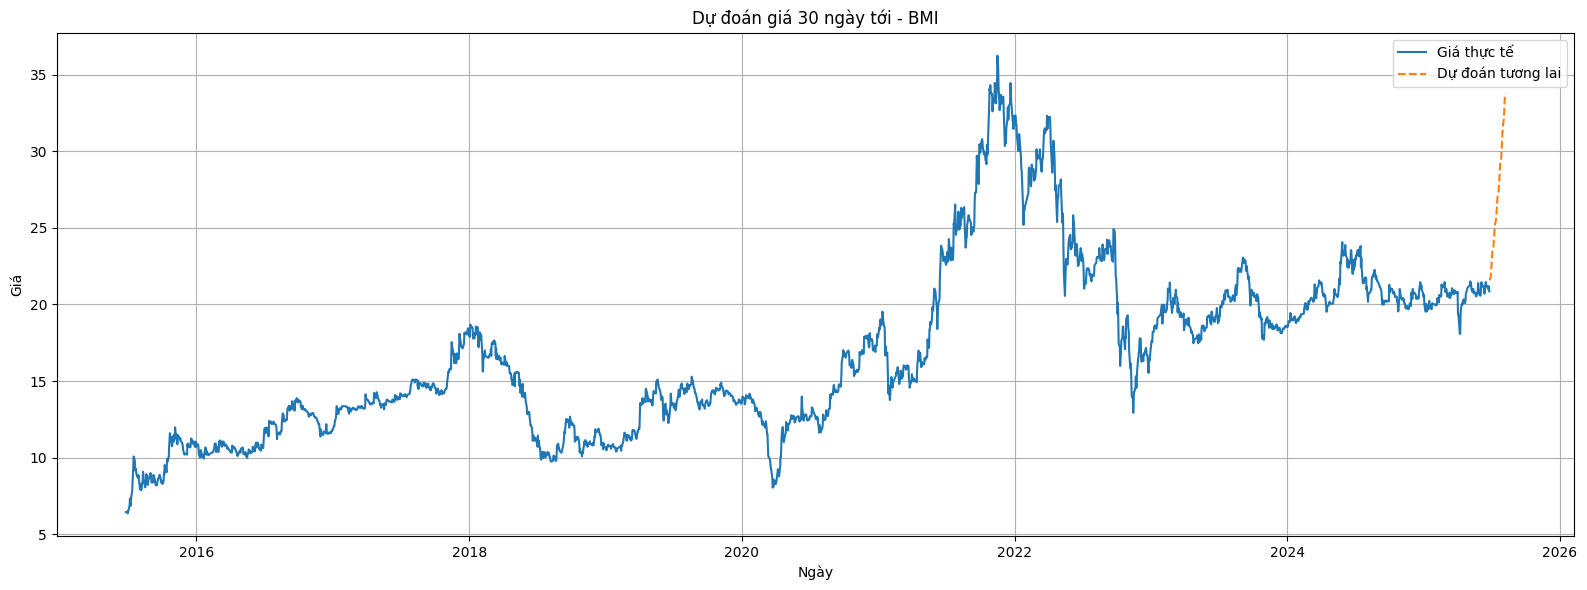

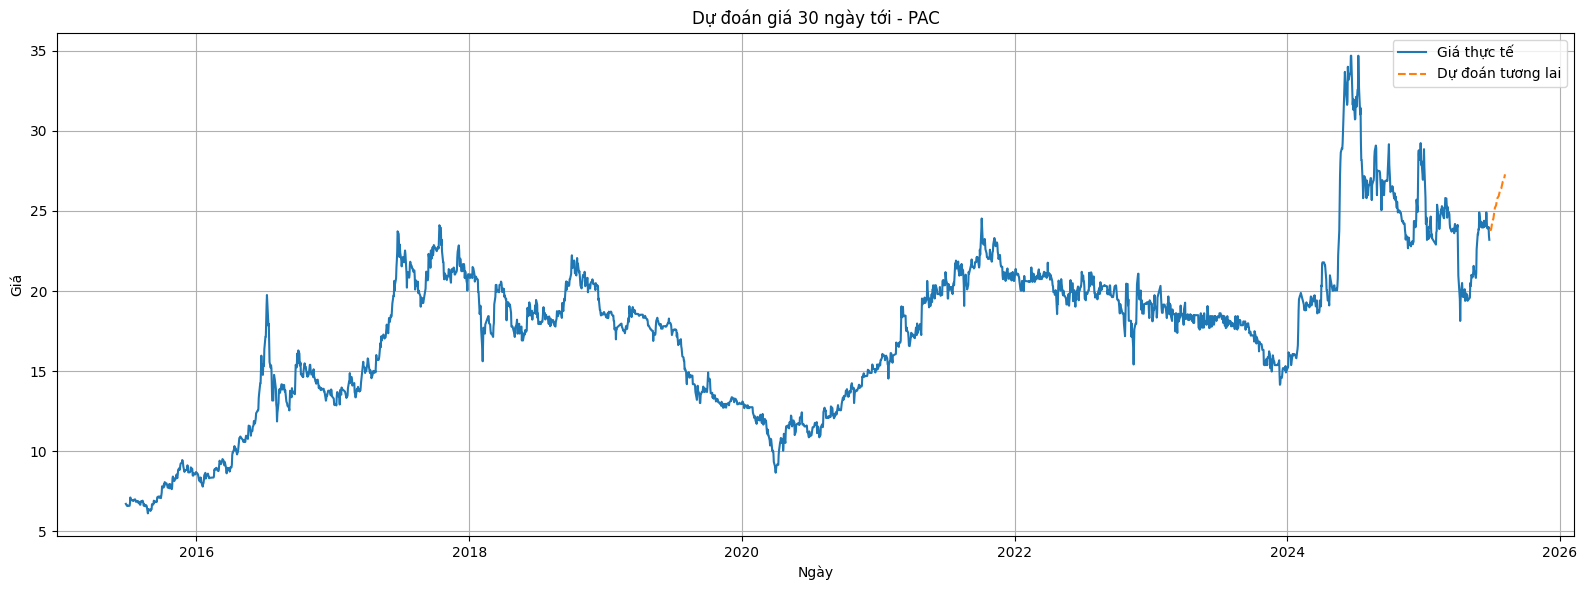

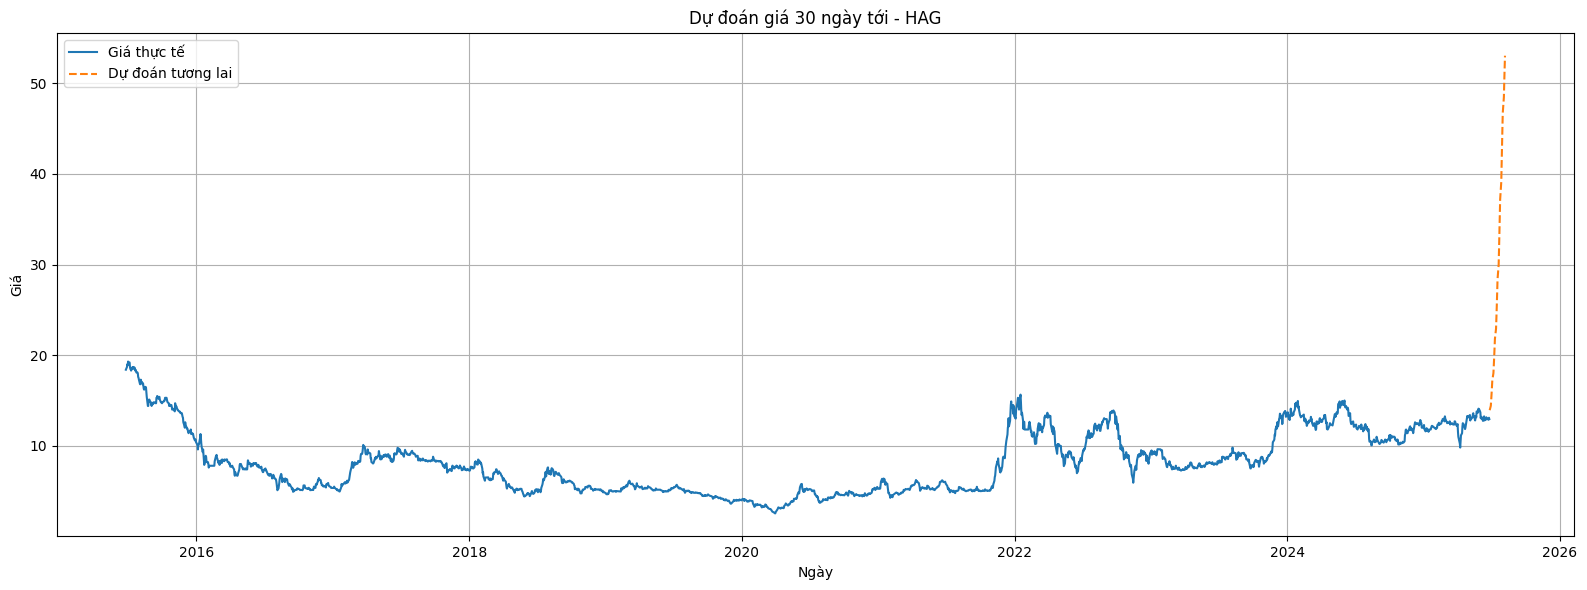

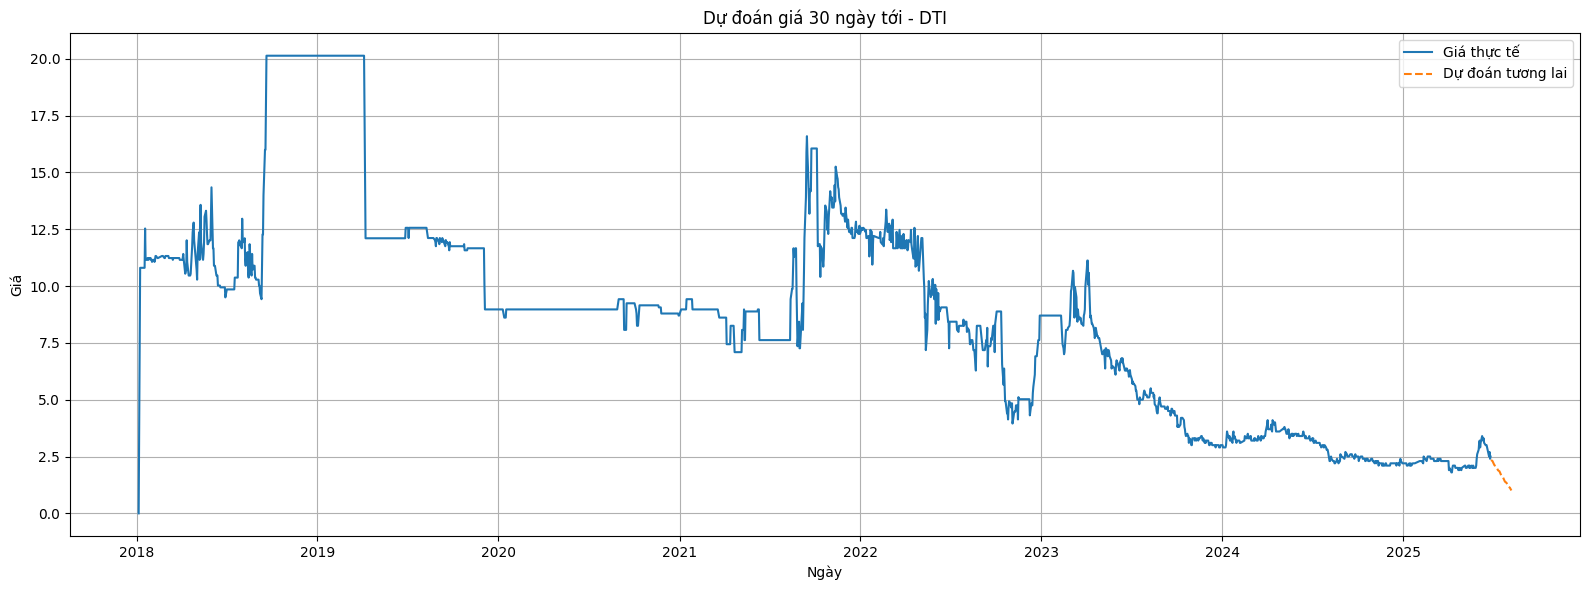

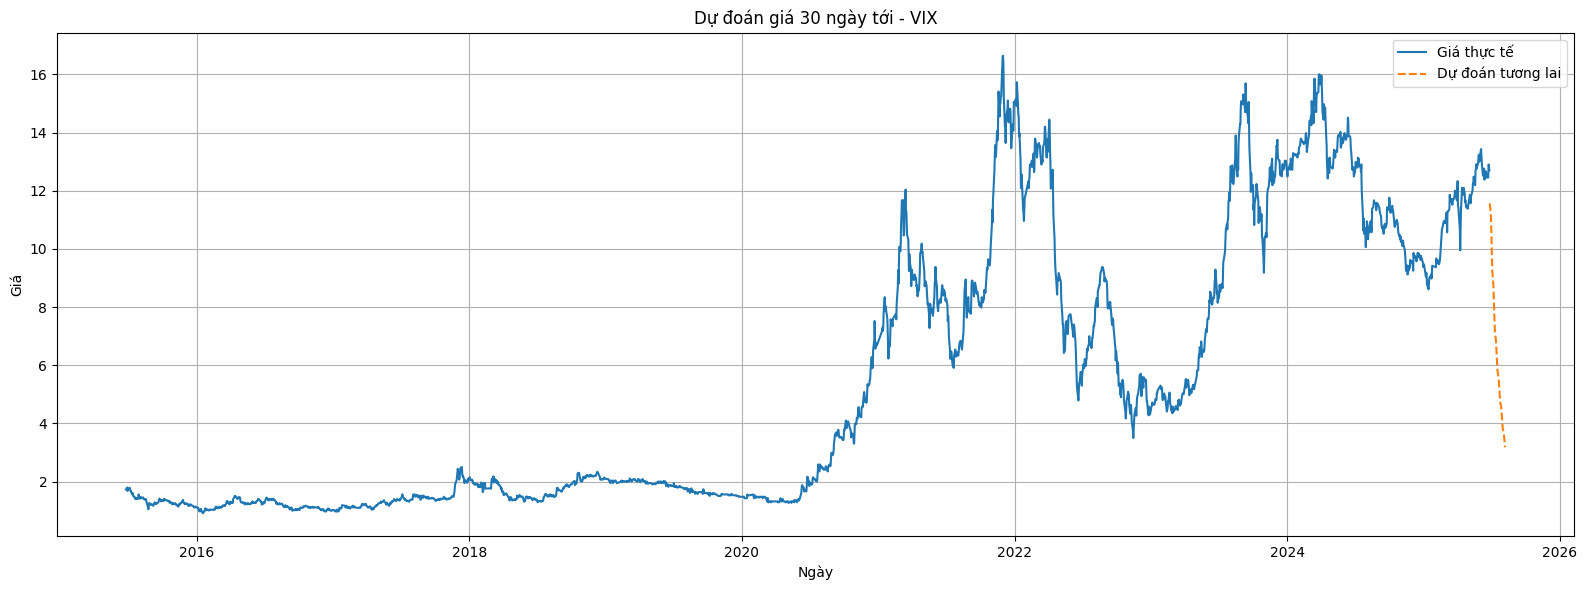

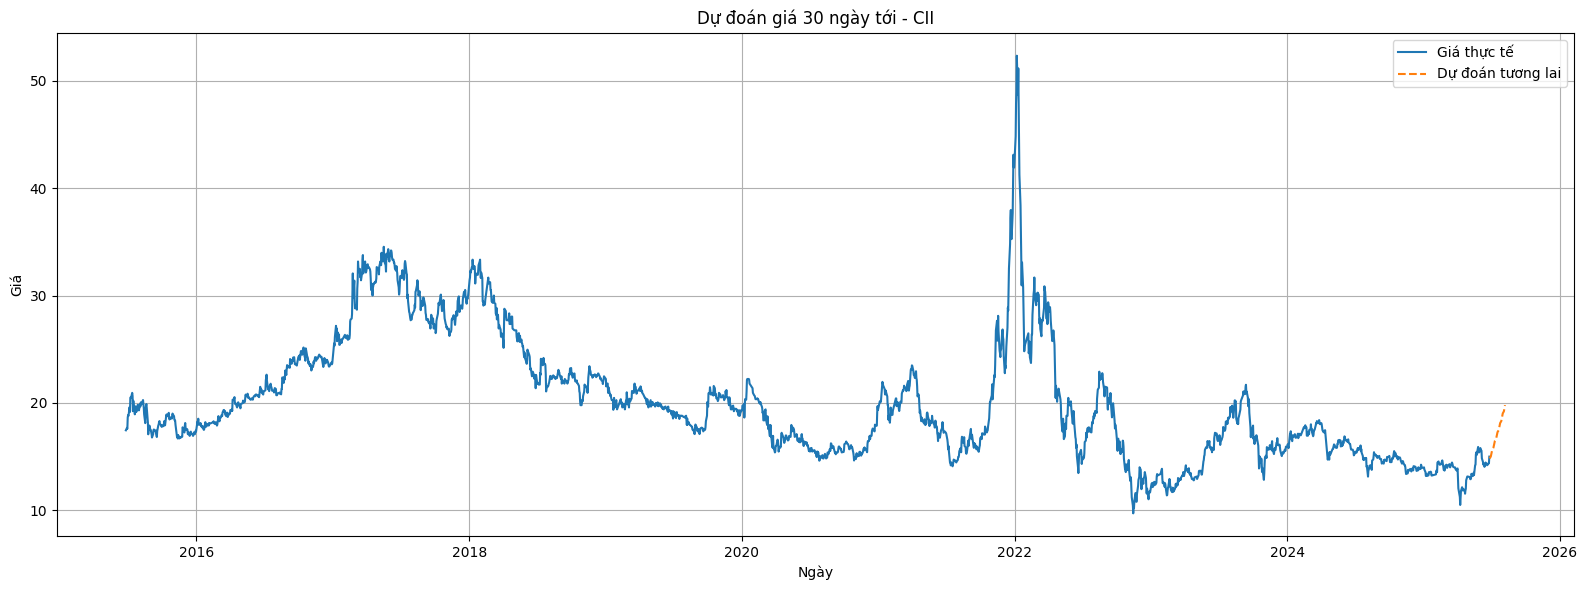

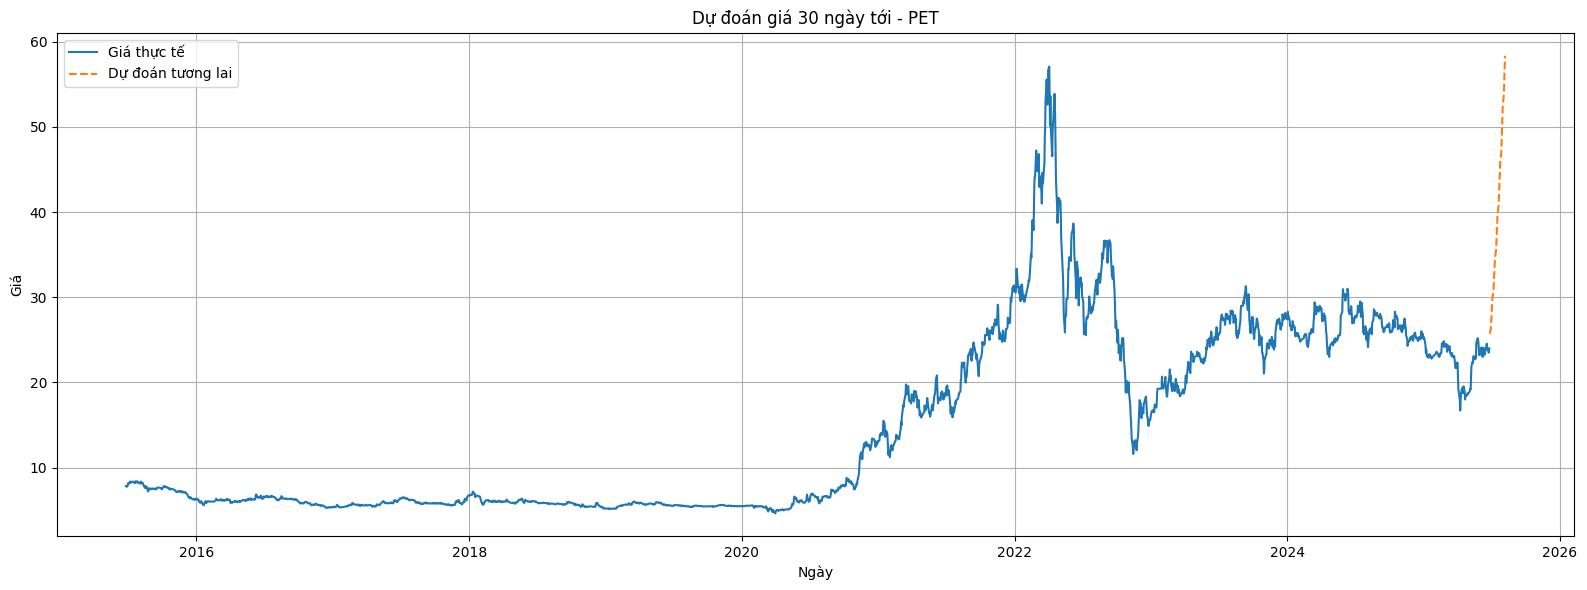

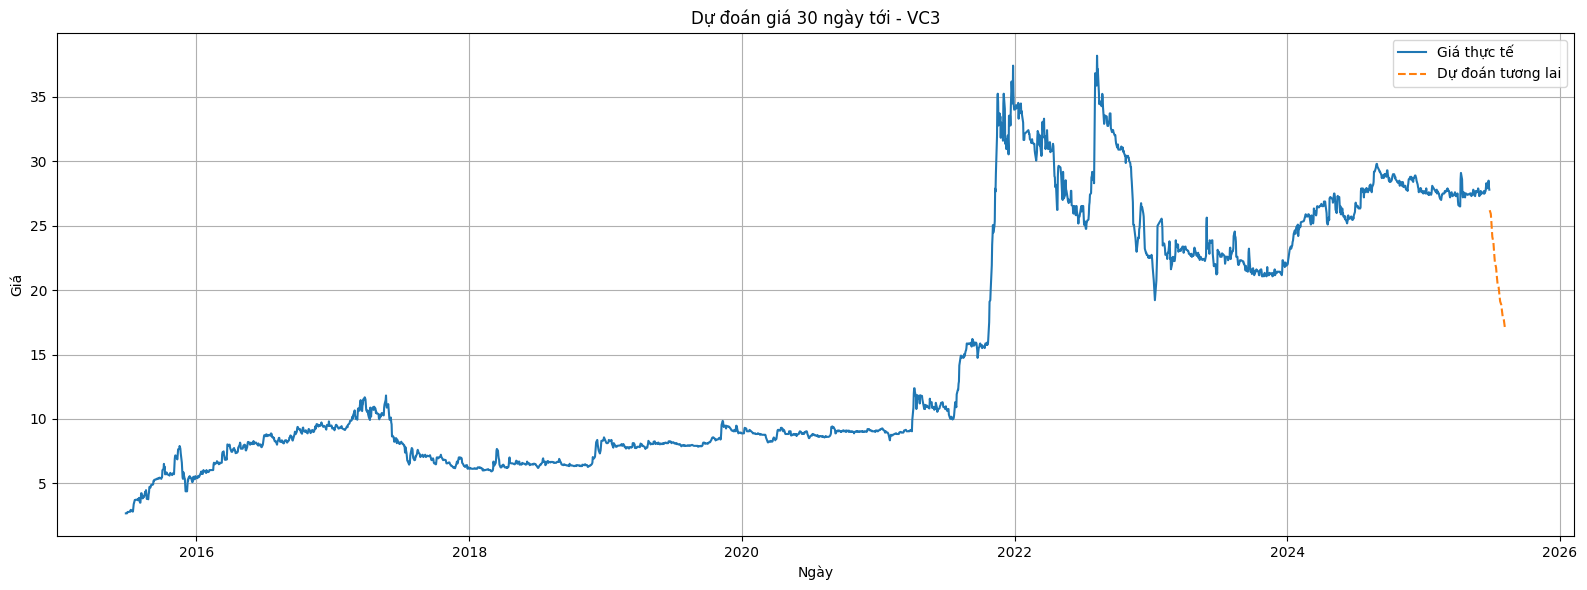

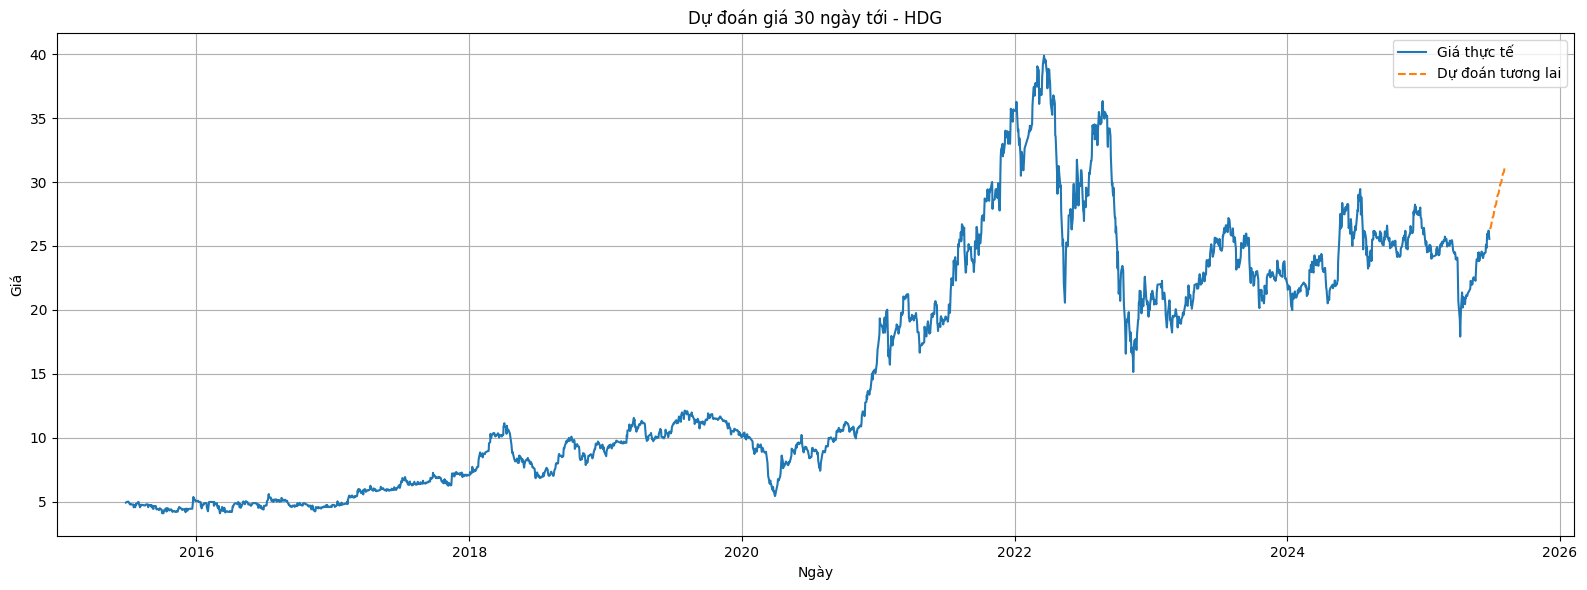

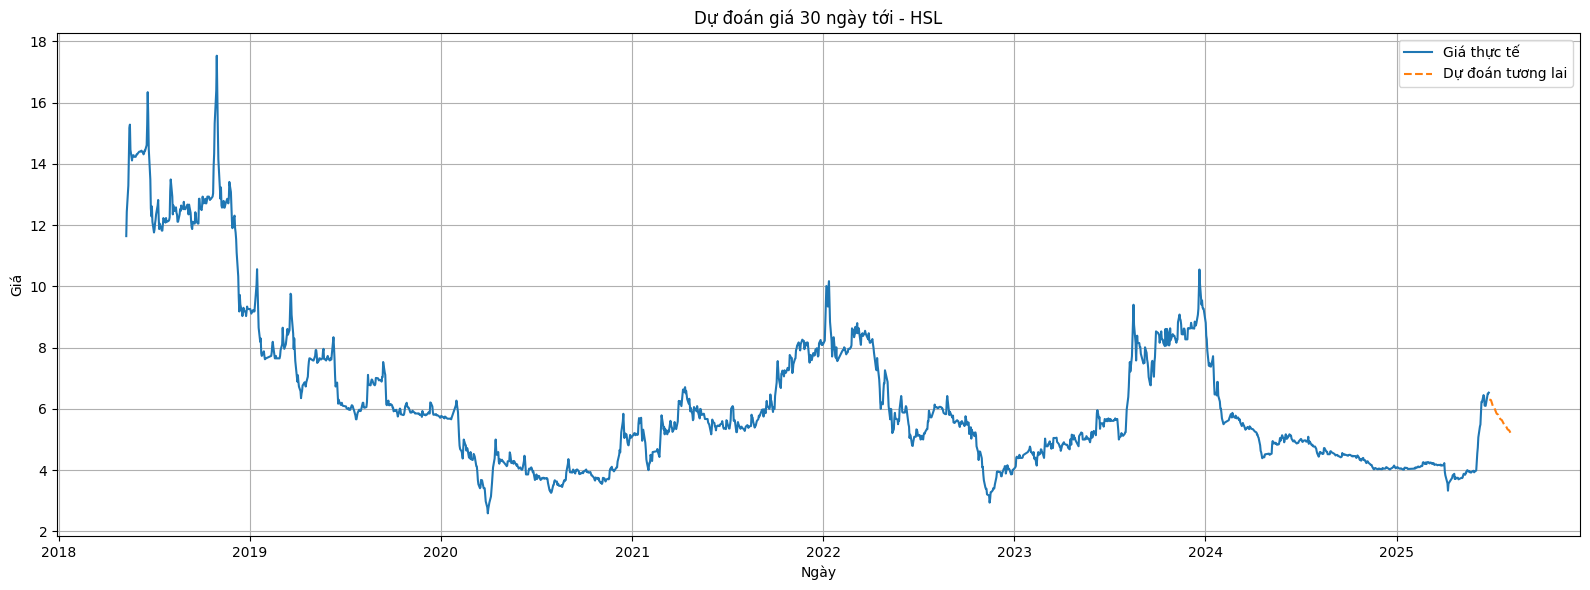

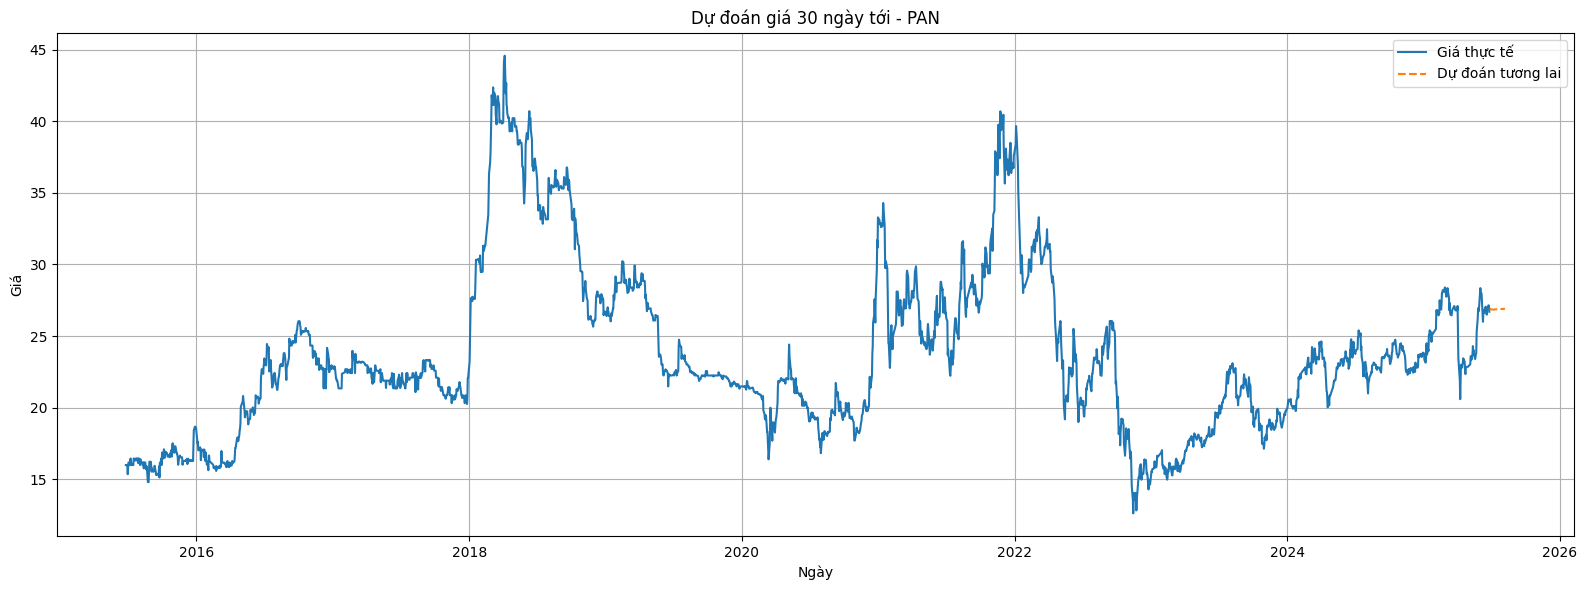

In [15]:
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

for t, ticker in enumerate(all_tickers):
    model_path = f"models/{ticker}_lstm_model.h5"
    model = load_model(model_path)

    # Load dữ liệu
    filePath = f"data_vnstock/{ticker}.csv"
    df = pd.read_csv(filePath, parse_dates=['time'], index_col='time')
    df = df[['close']].copy()
    df.dropna(inplace=True)

    # Xác định độ dài train
    training_data_len = int(len(df) * 0.95)
    train_data = df[['close']].values[:training_data_len]

    # Fit scaler trên dữ liệu train (giống lúc huấn luyện)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train_data)

    # Transform toàn bộ để lấy đoạn 30 ngày gần nhất
    scaled_data = scaler.transform(df[['close']].values)
    last_30 = scaled_data[-30:]

    # Dự đoán 30 bước tiếp theo
    predicted = []
    current_input = last_30.copy()

    for _ in range(30):
        input_seq = current_input.reshape(1, 30, 1)
        next_pred = model.predict(input_seq, verbose=0)[0][0]
        predicted.append(next_pred)
        current_input = np.append(current_input[1:], [[next_pred]], axis=0)

    # Inverse transform về đơn vị gốc
    predicted_prices = scaler.inverse_transform(np.array(predicted).reshape(-1, 1))

    # Tạo dãy ngày tương lai
    last_date = df.index[-1]
    future_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=30)

    df_future = pd.DataFrame({'Predicted_Close': predicted_prices.flatten()}, index=future_dates)

    # Vẽ biểu đồ
    plt.figure(figsize=(16, 6))
    plt.title(f'Dự đoán giá 30 ngày tới - {ticker}')
    plt.plot(df['close'], label='Giá thực tế')
    plt.plot(df_future['Predicted_Close'], label='Dự đoán tương lai', linestyle='--')
    plt.xlabel('Ngày')
    plt.ylabel('Giá')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
